# **Analyze Proximal and Distal Cells from Immune Cell Hubs**
Cell composition and differential gene expression analysis

# **Setup the environment**

In [1]:
%%capture
!pip install -q scanpy==1.10.1
!pip install -q anndata==0.10.7
!pip install -q squidpy==1.6.1
!pip install -q rasterio==1.4.3
!pip install -q google-cloud-storage

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

c:\Users\ChengYiChen\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

# **Load annotated scanpy instance**

In [3]:
ad = sc.read_h5ad("./HumanUterineCancerPatient2-ROCostain_annotated.hdf5")
ad

AnnData object with n_obs × n_vars = 74392 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount', 'volume_factor', 'leiden', 'manual_annot'
    var: 'mean', 'std'
    uns: 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'manual_annot_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Create a connectivity graph and spatial_distances of cells within 100 um radius

In [4]:
sq.gr.spatial_neighbors(ad, coord_type="generic", radius = 100, spatial_key="spatial")

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:01)


The sparse dataframe adata.obsp['spatial_distances'] stores cell distance based on obsm['spatial'] in um. </br>
Use this information to determine proximal-distal cells


## Get the paired distances df with cell ids and cel type

In [5]:
# Import necessary libraries
from scipy.sparse import coo_matrix # for Coordinate list formatting

# Create distance df

spatial_distances = ad.obsp["spatial_distances"]
spatial_distances_coo = spatial_distances.tocoo()

distances_df = pd.DataFrame({
    "source": spatial_distances_coo.row,   # Source cell indices
    "target": spatial_distances_coo.col,   # Neighbor cell indices
    "distance": spatial_distances_coo.data  # Distances between the cells
})

distances_df["source"] = distances_df["source"].astype(object)
distances_df["target"] = distances_df["target"].astype(object)
distances_df.loc[:, "source"] = distances_df["source"].map(dict(enumerate(ad.obs.index)))
distances_df.loc[:, "target"] = distances_df["target"].map(dict(enumerate(ad.obs.index)))

distances_df['source_cell_type'] = distances_df['source'].map(ad.obs['manual_annot'].to_dict())
distances_df['target_cell_type'] = distances_df['target'].map(ad.obs['manual_annot'].to_dict())

distances_df

source              target   distance source_cell_type  \
0        267305200237100734  267305200237200180  56.035516      Immune cell   
1        267305200237100734  267305200237100682  14.125946      Immune cell   
2        267305200237100734  267305200237100958  83.012572      Immune cell   
3        267305200237100734  267305200237101381  99.705066      Immune cell   
4        267305200237100734  267305200237100415  79.069300      Immune cell   
...                     ...                 ...        ...              ...   
2799025  267305200237100747  267305200237100780  12.817553    Cancer cell_3   
2799026  267305200237100747  267305200237200092  74.360927    Cancer cell_3   
2799027  267305200237100747  267305200237100547  29.474549    Cancer cell_3   
2799028  267305200237100747  267305200237200620  83.904320    Cancer cell_3   
2799029  267305200237100747  267305200237100526  29.013061    Cancer cell_3   

                   target_cell_type  
0                     Cancer cell_2  
1                     Cancer cell_3  
2                     Cancer cell_3  
3                     Cancer cell_2  
4                     Cancer cell_3  
...                             ...  
2799025               Cancer cell_3  
2799026                 Immune cell  
2799027  Endometrium (inflammating)  
2799028               Cancer cell_2  
2799029               Cancer cell_3  

[2799030 rows x 5 columns]

# Define hub cells (immune cell)

In [6]:
# get hub cell ids
hub_cell_id = distances_df.loc[distances_df['source_cell_type'].str.startswith('Immune'), 'source']
print(len(hub_cell_id))

# get neighbors
cell_from_hub = distances_df.copy()
cell_from_hub = cell_from_hub[(cell_from_hub['source'].isin(hub_cell_id)) & ~(cell_from_hub['target'].isin(hub_cell_id))] # ensure there is no hub cells included in targets

cell_from_hub

357897


source              target   distance source_cell_type  \
0        267305200237100734  267305200237200180  56.035516      Immune cell   
1        267305200237100734  267305200237100682  14.125946      Immune cell   
2        267305200237100734  267305200237100958  83.012572      Immune cell   
3        267305200237100734  267305200237101381  99.705066      Immune cell   
4        267305200237100734  267305200237100415  79.069300      Immune cell   
...                     ...                 ...        ...              ...   
2798533  267305200322102964  267305200322102633  70.476820      Immune cell   
2798534  267305200322102964  267305200343100271  96.027826      Immune cell   
2798536  267305200322102964  267305200322103196  40.835703      Immune cell   
2798537  267305200322102964  267305200322103215  48.117615      Immune cell   
2798538  267305200322102964  267305200322103249  57.533589      Immune cell   

        target_cell_type  
0          Cancer cell_2  
1          Cancer cell_3  
2          Cancer cell_3  
3          Cancer cell_2  
4          Cancer cell_3  
...                  ...  
2798533    Smooth muscle  
2798534    Cancer cell_1  
2798536    Smooth muscle  
2798537      Endothelium  
2798538      Endothelium  

[265833 rows x 5 columns]

## calculate the distance from hub cells to each cell type

In [7]:
# sort by mean
display(cell_from_hub.groupby('target_cell_type')['distance'].describe().sort_values('mean', ascending = True))

# sort by median
display(pd.DataFrame(cell_from_hub.groupby('target_cell_type')['distance'].median().sort_values(ascending = True)))

count       mean        std       min  \
target_cell_type                                                                
Endothelium                           12137.0  63.786320  24.775436  4.353185   
Smooth muscle                         21690.0  64.597381  24.468223  4.458403   
Cancer cell_8 (Metastasis/Senescent)  10580.0  65.802572  23.562429  3.796181   
Endometrium (inflammating)             8850.0  66.878791  23.299677  4.128892   
Cancer cell_3                         25757.0  67.732072  22.690497  4.081685   
Cancer cell_7                          6887.0  68.200051  22.702759  5.314126   
Cancer cell_2                         25615.0  68.498687  22.488990  5.150859   
Endometrium (antigen presenting)      26538.0  68.603436  22.217921  3.612607   
Cancer cell_4                         13966.0  68.731797  22.243059  4.570208   
Endometrium                           61197.0  68.793322  22.126763  4.461386   
Cancer cell_5                         18865.0  69.419006  21.939562  4.366814   
Cancer cell_1                         16497.0  69.704053  22.102729  4.508620   
Cancer stem cell                       6354.0  69.953672  21.649579  6.158875   
Cancer cell_6 (Metastasis)             6451.0  70.426891  21.981550  5.587537   
Cancer cell_9                          4449.0  71.717910  20.409727  7.983850   

                                            25%        50%        75%  \
target_cell_type                                                        
Endothelium                           44.988811  67.407554  85.096934   
Smooth muscle                         46.400062  68.387412  85.537262   
Cancer cell_8 (Metastasis/Senescent)  49.200288  69.076961  85.840220   
Endometrium (inflammating)            50.603337  70.632328  86.509881   
Cancer cell_3                         51.930075  71.359244  86.910884   
Cancer cell_7                         52.505784  72.203131  87.369987   
Cancer cell_2                         52.634434  72.467174  87.502266   
Endometrium (antigen presenting)      53.126930  72.489999  87.265869   
Cancer cell_4                         53.432102  72.866205  87.274583   
Endometrium                           53.264627  72.663777  87.395597   
Cancer cell_5                         54.335216  73.177301  87.925754   
Cancer cell_1                         54.601702  74.159839  88.285810   
Cancer stem cell                      55.082433  73.777801  88.429125   
Cancer cell_6 (Metastasis)            56.221795  74.834590  88.586960   
Cancer cell_9                         57.456910  75.284461  88.886974   

                                            max  
target_cell_type                                 
Endothelium                           99.997309  
Smooth muscle                         99.994666  
Cancer cell_8 (Metastasis/Senescent)  99.998353  
Endometrium (inflammating)            99.990624  
Cancer cell_3                         99.999226  
Cancer cell_7                         99.980163  
Cancer cell_2                         99.999579  
Endometrium (antigen presenting)      99.997810  
Cancer cell_4                         99.996918  
Endometrium                           99.999896  
Cancer cell_5                         99.998374  
Cancer cell_1                         99.997353  
Cancer stem cell                      99.997894  
Cancer cell_6 (Metastasis)            99.999476  
Cancer cell_9                         99.995176

distance
target_cell_type                               
Endothelium                           67.407554
Smooth muscle                         68.387412
Cancer cell_8 (Metastasis/Senescent)  69.076961
Endometrium (inflammating)            70.632328
Cancer cell_3                         71.359244
Cancer cell_7                         72.203131
Cancer cell_2                         72.467174
Endometrium (antigen presenting)      72.489999
Endometrium                           72.663777
Cancer cell_4                         72.866205
Cancer cell_5                         73.177301
Cancer stem cell                      73.777801
Cancer cell_1                         74.159839
Cancer cell_6 (Metastasis)            74.834590
Cancer cell_9                         75.284461

## Calculate the proportion of neighbor cell types

In [8]:
dist_thr = 10
print(f'Within {dist_thr} um distance')
proximal_cells = cell_from_hub[cell_from_hub['distance'] <= dist_thr].copy()
display(pd.DataFrame({'count' : proximal_cells['target_cell_type'].value_counts(),
              'ratio' : proximal_cells['target_cell_type'].value_counts(normalize=True)}))


dist_thr = 20
print(f'Within {dist_thr} um distance')
proximal_cells = cell_from_hub[cell_from_hub['distance'] <= dist_thr].copy()
display(pd.DataFrame({'count' : proximal_cells['target_cell_type'].value_counts(),
              'ratio' : proximal_cells['target_cell_type'].value_counts(normalize=True)}))

Within 10 um distance


count     ratio
target_cell_type                                     
Smooth muscle                           244  0.170510
Endometrium                             242  0.169113
Endothelium                             140  0.097834
Cancer cell_3                           138  0.096436
Cancer cell_2                            99  0.069182
Endometrium (antigen presenting)         96  0.067086
Cancer cell_8 (Metastasis/Senescent)     89  0.062194
Endometrium (inflammating)               82  0.057303
Cancer cell_1                            76  0.053110
Cancer cell_5                            69  0.048218
Cancer cell_4                            55  0.038435
Cancer cell_6 (Metastasis)               40  0.027952
Cancer cell_7                            37  0.025856
Cancer stem cell                         20  0.013976
Cancer cell_9                             4  0.002795

Within 20 um distance


count     ratio
target_cell_type                                     
Endometrium                            1448  0.185237
Smooth muscle                          1162  0.148650
Cancer cell_3                           752  0.096201
Cancer cell_2                           688  0.088013
Endothelium                             679  0.086862
Endometrium (antigen presenting)        649  0.083024
Cancer cell_8 (Metastasis/Senescent)    440  0.056288
Cancer cell_5                           427  0.054625
Cancer cell_1                           384  0.049124
Cancer cell_4                           358  0.045798
Endometrium (inflammating)              304  0.038890
Cancer cell_7                           202  0.025841
Cancer cell_6 (Metastasis)              156  0.019957
Cancer stem cell                        120  0.015351
Cancer cell_9                            48  0.006140

## Use chi-square test to validate whether the observed cell type ratios are statistically different from whole tissue observations

In [9]:
cell_type_count_df = pd.DataFrame({'whole_tissue_count' : ad.obs['manual_annot'].value_counts(),
                         'count_within_10um' : cell_from_hub.loc[cell_from_hub['distance'] <= 10, 'target_cell_type'].value_counts(),
                         'count_within_20um' : cell_from_hub.loc[cell_from_hub['distance'] <= 20, 'target_cell_type'].value_counts()})

cell_type_count_df = cell_type_count_df.loc[~cell_type_count_df.index.str.startswith('Immune'), :].copy() # remove immune cells from the count dataframe to focus on comparing the rest cell types
display(cell_type_count_df)

whole_tissue_count  count_within_10um  \
Cancer cell_1                                       7877               76.0   
Cancer cell_2                                       5829               99.0   
Cancer cell_3                                       5464              138.0   
Cancer cell_4                                       5198               55.0   
Cancer cell_5                                       5092               69.0   
Cancer cell_6 (Metastasis)                          3000               40.0   
Cancer cell_7                                       2827               37.0   
Cancer cell_8 (Metastasis/Senescent)                1847               89.0   
Cancer cell_9                                        755                4.0   
Cancer stem cell                                    3608               20.0   
Endometrium                                        10895              242.0   
Endometrium (antigen presenting)                    4184               96.0   
Endometrium (inflammating)                          2724               82.0   
Endothelium                                         1933              140.0   
Smooth muscle                                       2911              244.0   

                                      count_within_20um  
Cancer cell_1                                     384.0  
Cancer cell_2                                     688.0  
Cancer cell_3                                     752.0  
Cancer cell_4                                     358.0  
Cancer cell_5                                     427.0  
Cancer cell_6 (Metastasis)                        156.0  
Cancer cell_7                                     202.0  
Cancer cell_8 (Metastasis/Senescent)              440.0  
Cancer cell_9                                      48.0  
Cancer stem cell                                  120.0  
Endometrium                                      1448.0  
Endometrium (antigen presenting)                  649.0  
Endometrium (inflammating)                        304.0  
Endothelium                                       679.0  
Smooth muscle                                    1162.0

In [10]:
import scipy.stats as stats

# Perform chi-square test for count_within_10um vs whole_tissue_count
chi2_10um, p_10um, dof_10um, expected_10um = stats.chi2_contingency([cell_type_count_df["count_within_10um"], cell_type_count_df["whole_tissue_count"]])

# Perform chi-square test for count_within_20um vs whole_tissue_count
chi2_20um, p_20um, dof_20um, expected_20um = stats.chi2_contingency([cell_type_count_df["count_within_20um"], cell_type_count_df["whole_tissue_count"]])

# Display results
chi2_results = pd.DataFrame({
        "Comparison": ["count_within_10um vs whole_tissue", "count_within_20um vs whole_tissue"],
        "Chi-Square Statistic": [chi2_10um, chi2_20um],
        "p-value": [p_10um, p_20um],
        "Degrees of Freedom": [dof_10um, dof_20um]
    })
display(chi2_results)


# Calculate observed vs expected deviations for count_within_10um
observed_10um = cell_type_count_df["count_within_10um"]
expected_10um = expected_10um[0]  # Extract expected counts for count_within_10um
deviation_10um = (observed_10um - expected_10um) / expected_10um  # Relative deviation

# Calculate observed vs expected deviations for count_within_20um
observed_20um = cell_type_count_df["count_within_20um"]
expected_20um = expected_20um[0]  # Extract expected counts for count_within_20um
deviation_20um = (observed_20um - expected_20um) / expected_20um  # Relative deviation

# Create a summary dataframe
significant_representation = pd.DataFrame({
        "Cell Type": cell_type_count_df.index,
        "Observed_10um": observed_10um,
        "Expected_10um": expected_10um,
        "Deviation_10um": deviation_10um,
        "Observed_20um": observed_20um,
        "Expected_20um": expected_20um,
        "Deviation_20um": deviation_20um
    }).sort_values(by=["Deviation_10um", "Deviation_20um"], ascending=False)

display(significant_representation)

Comparison  Chi-Square Statistic        p-value  \
0  count_within_10um vs whole_tissue            909.303424  4.382959e-185   
1  count_within_20um vs whole_tissue           3062.558105   0.000000e+00   

   Degrees of Freedom  
0                  14  
1                  14

Cell Type  \
Smooth muscle                                                Smooth muscle   
Endothelium                                                    Endothelium   
Cancer cell_8 (Metastasis/Senescent)  Cancer cell_8 (Metastasis/Senescent)   
Endometrium (inflammating)                      Endometrium (inflammating)   
Cancer cell_3                                                Cancer cell_3   
Endometrium (antigen presenting)          Endometrium (antigen presenting)   
Endometrium                                                    Endometrium   
Cancer cell_2                                                Cancer cell_2   
Cancer cell_5                                                Cancer cell_5   
Cancer cell_6 (Metastasis)                      Cancer cell_6 (Metastasis)   
Cancer cell_7                                                Cancer cell_7   
Cancer cell_4                                                Cancer cell_4   
Cancer cell_1                                                Cancer cell_1   
Cancer stem cell                                          Cancer stem cell   
Cancer cell_9                                                Cancer cell_9   

                                      Observed_10um  Expected_10um  \
Smooth muscle                                 244.0      68.849485   
Endothelium                                   140.0      45.237713   
Cancer cell_8 (Metastasis/Senescent)           89.0      42.248052   
Endometrium (inflammating)                     82.0      61.233488   
Cancer cell_3                                 138.0     122.248753   
Endometrium (antigen presenting)               96.0      93.399619   
Endometrium                                   242.0     243.035410   
Cancer cell_2                                  99.0     129.362836   
Cancer cell_5                                  69.0     112.625101   
Cancer cell_6 (Metastasis)                     40.0      66.339916   
Cancer cell_7                                  37.0      62.499184   
Cancer cell_4                                  55.0     114.632756   
Cancer cell_1                                  76.0     173.553077   
Cancer stem cell                               20.0      79.171453   
Cancer cell_9                                   4.0      16.563157   

                                      Deviation_10um  Observed_20um  \
Smooth muscle                               2.543963         1162.0   
Endothelium                                 2.094763          679.0   
Cancer cell_8 (Metastasis/Senescent)        1.106606          440.0   
Endometrium (inflammating)                  0.339137          304.0   
Cancer cell_3                               0.128846          752.0   
Endometrium (antigen presenting)            0.027841          649.0   
Endometrium                                -0.004260         1448.0   
Cancer cell_2                              -0.234711          688.0   
Cancer cell_5                              -0.387348          427.0   
Cancer cell_6 (Metastasis)                 -0.397045          156.0   
Cancer cell_7                              -0.407992          202.0   
Cancer cell_4                              -0.520207          358.0   
Cancer cell_1                              -0.562094          384.0   
Cancer stem cell                           -0.747384          120.0   
Cancer cell_9                              -0.758500           48.0   

                                      Expected_20um  Deviation_20um  
Smooth muscle                            442.443004        1.626327  
Endothelium                              283.737080        1.393061  
Cancer cell_8 (Metastasis/Senescent)     248.432887        0.771102  
Endometrium (inflammating)               328.926446       -0.075781  
Cancer cell_3                            675.233418        0.113689  
Endometrium (antigen presenting)         525.000500        0.236189  
Endometrium                             1340.798919        0.079953 

* Positive Deviation (>0): The cell type is overrepresented in the subdomain compared to the whole tissue.
* Negative Deviation (<0): The cell type is underrepresented in the subdomain.
* Higher absolute values indicate stronger deviations from expectation.

* Smooth muscle and Endothelium are the most significantly overrepresented in both 10µm and 20µm subdomains.
* Cancer cell 8 (Metastasis/Senescent) also shows enrichment.

## Plot distances of target cell type from hubs in density plot

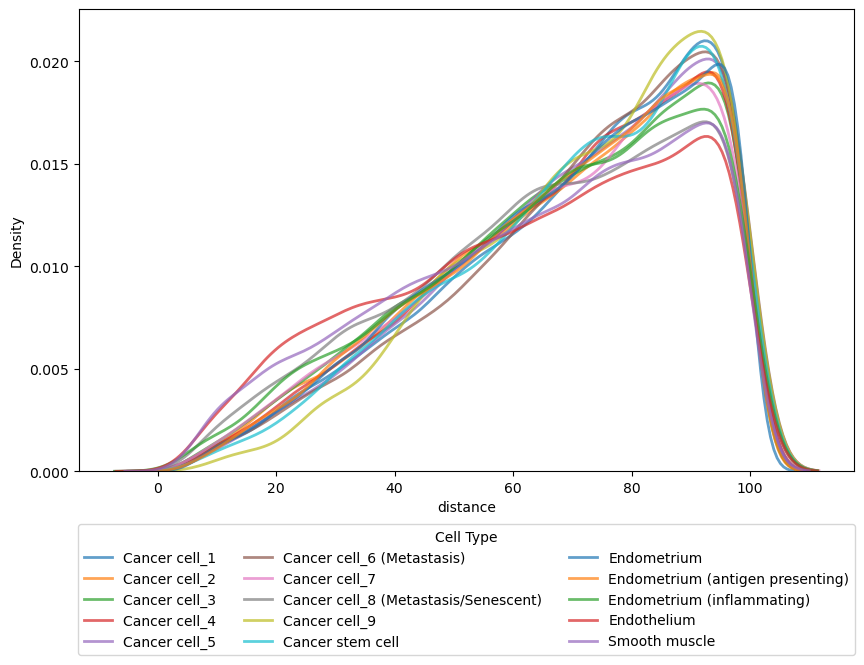

In [11]:
# Adjust plot size
plt.figure(figsize=(10, 6))

category_order = [c for c in ad.obs['manual_annot'].cat.categories if c in cell_from_hub['target_cell_type'].unique()]

# Plot the KDE plot with explicit labels
for category in category_order:
    subset = cell_from_hub[cell_from_hub['target_cell_type'] == category]
    sns.kdeplot(data=subset, x='distance', fill=False, alpha=0.7, label=category, linewidth = 2)

# Add legend explicitly
plt.legend(title='Cell Type', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# Show the plot
plt.show()

## Randomly plot 10 hub cell neighborhoods

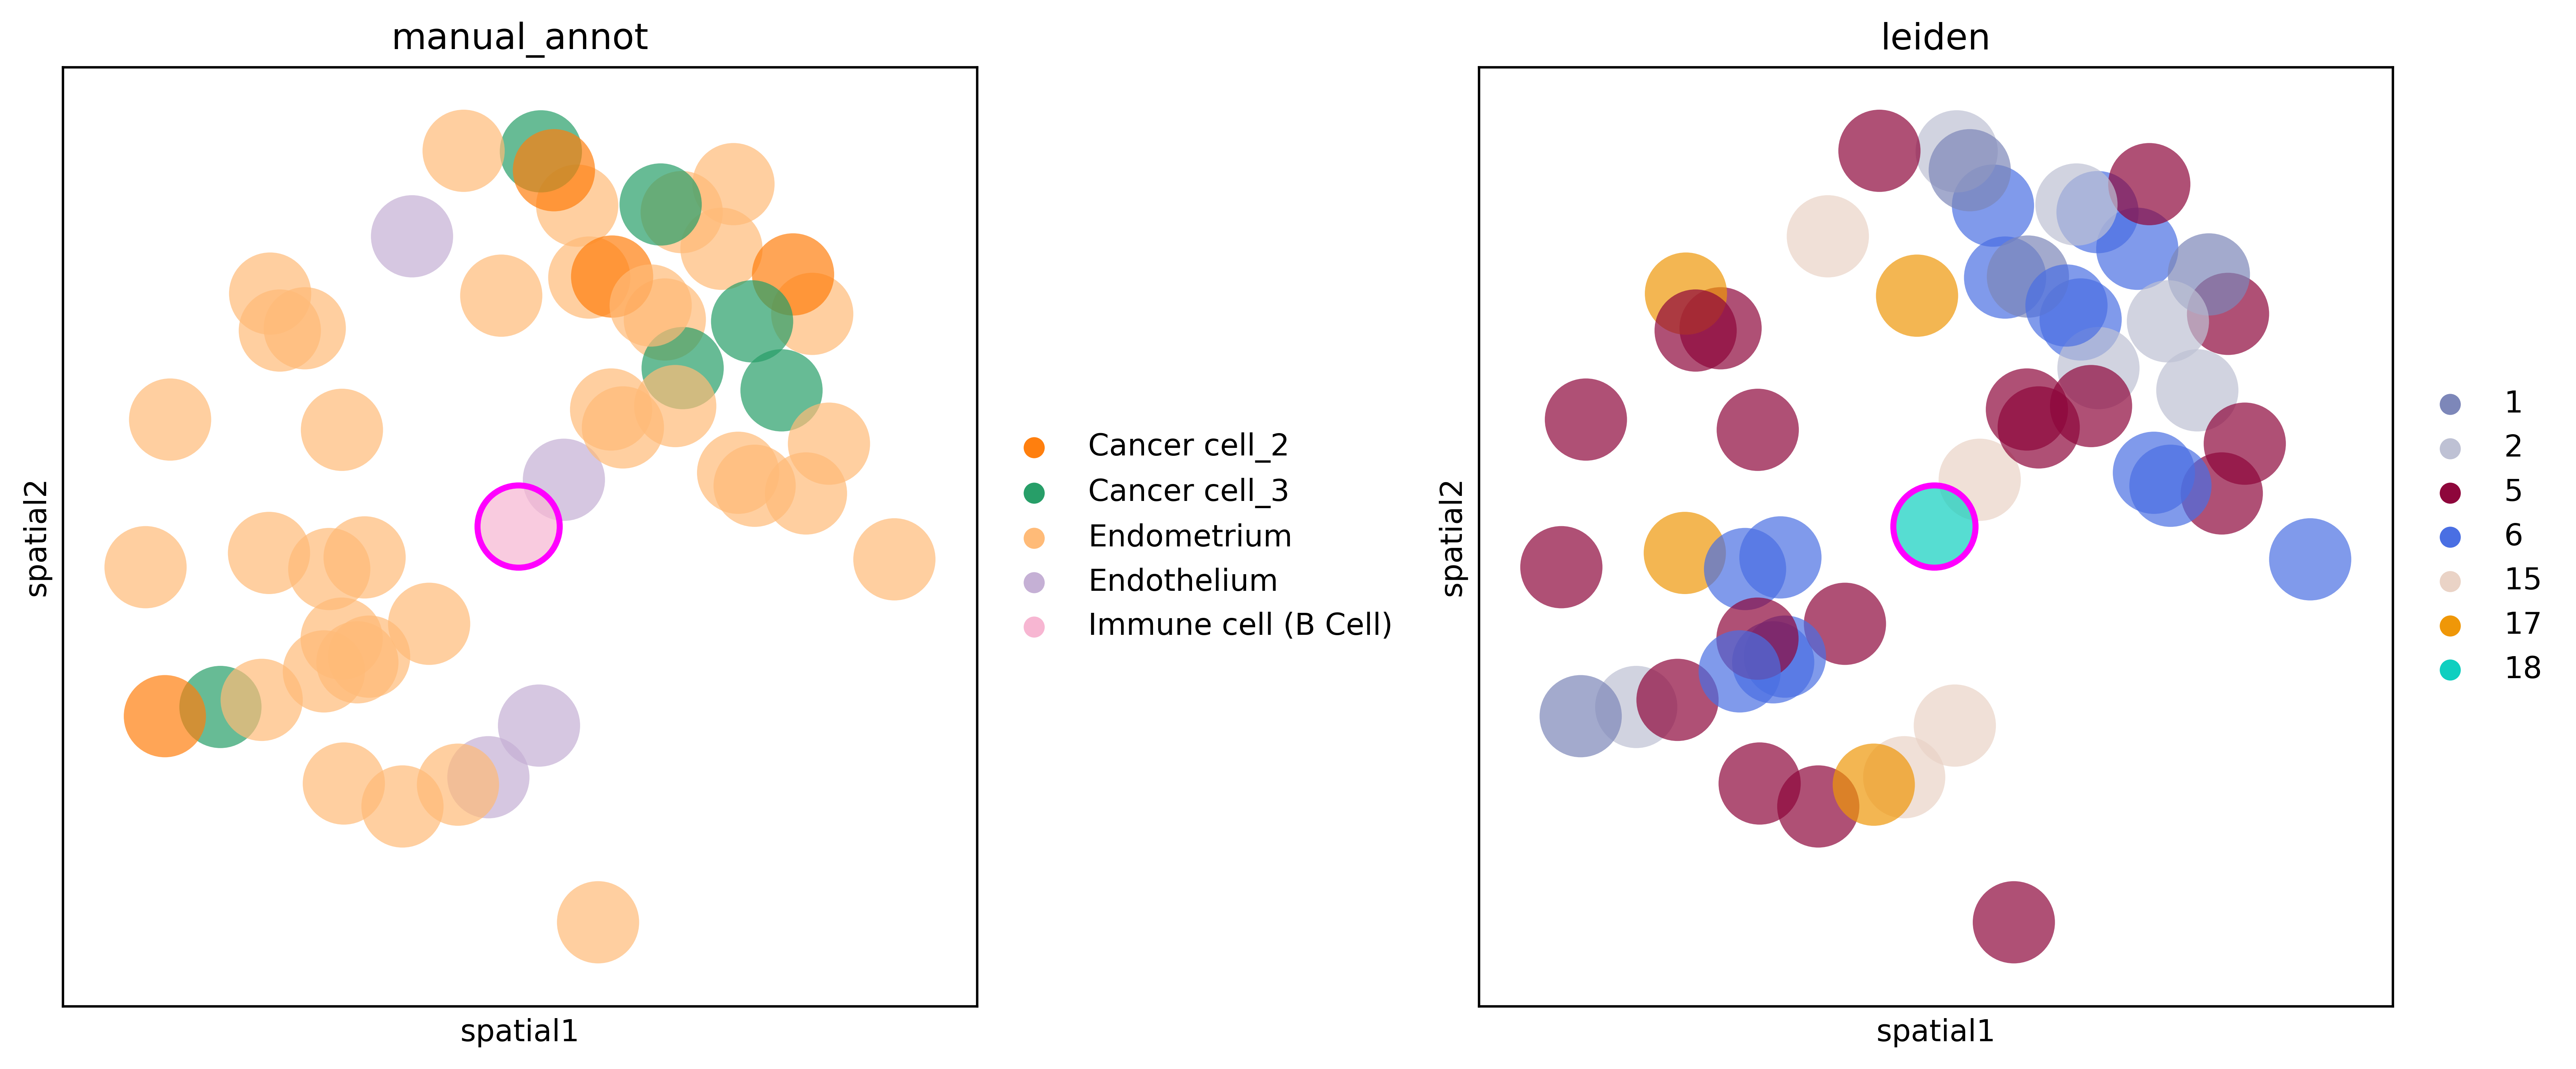

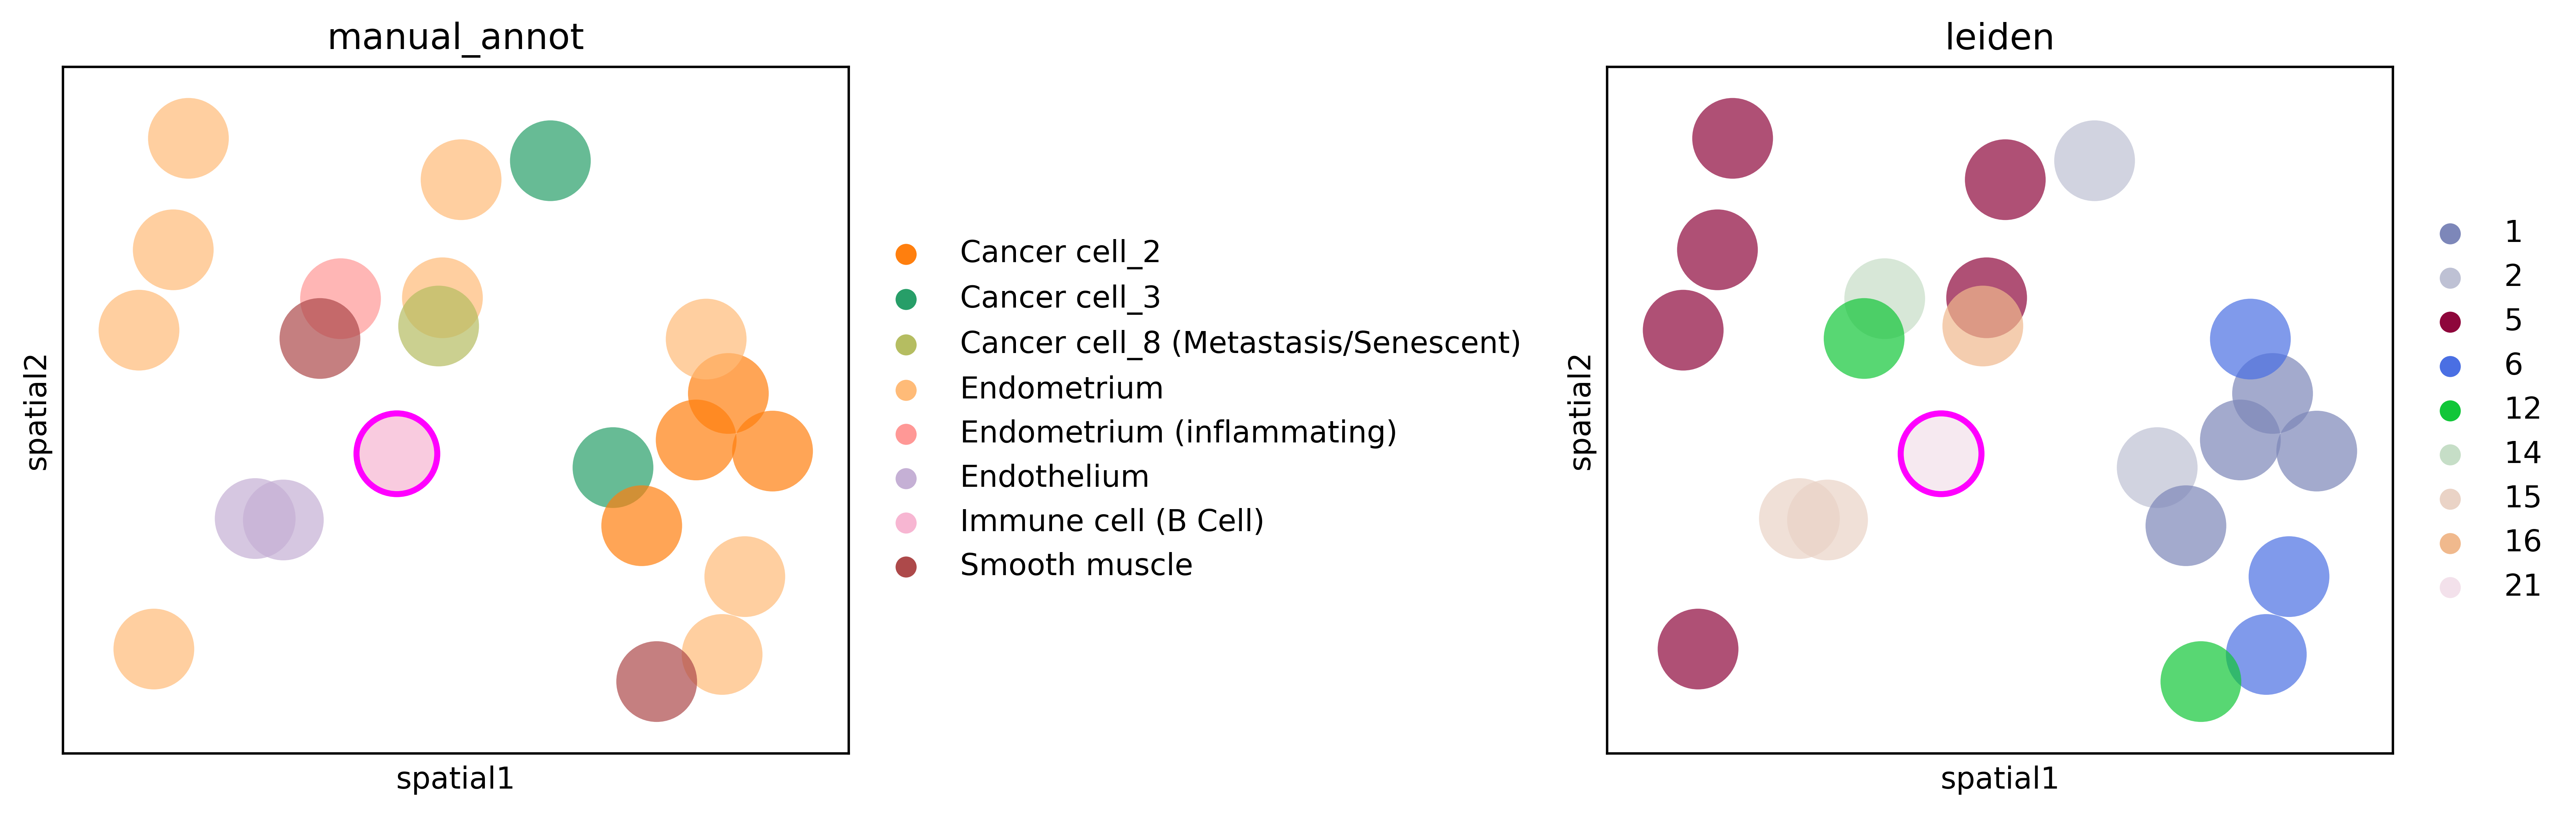

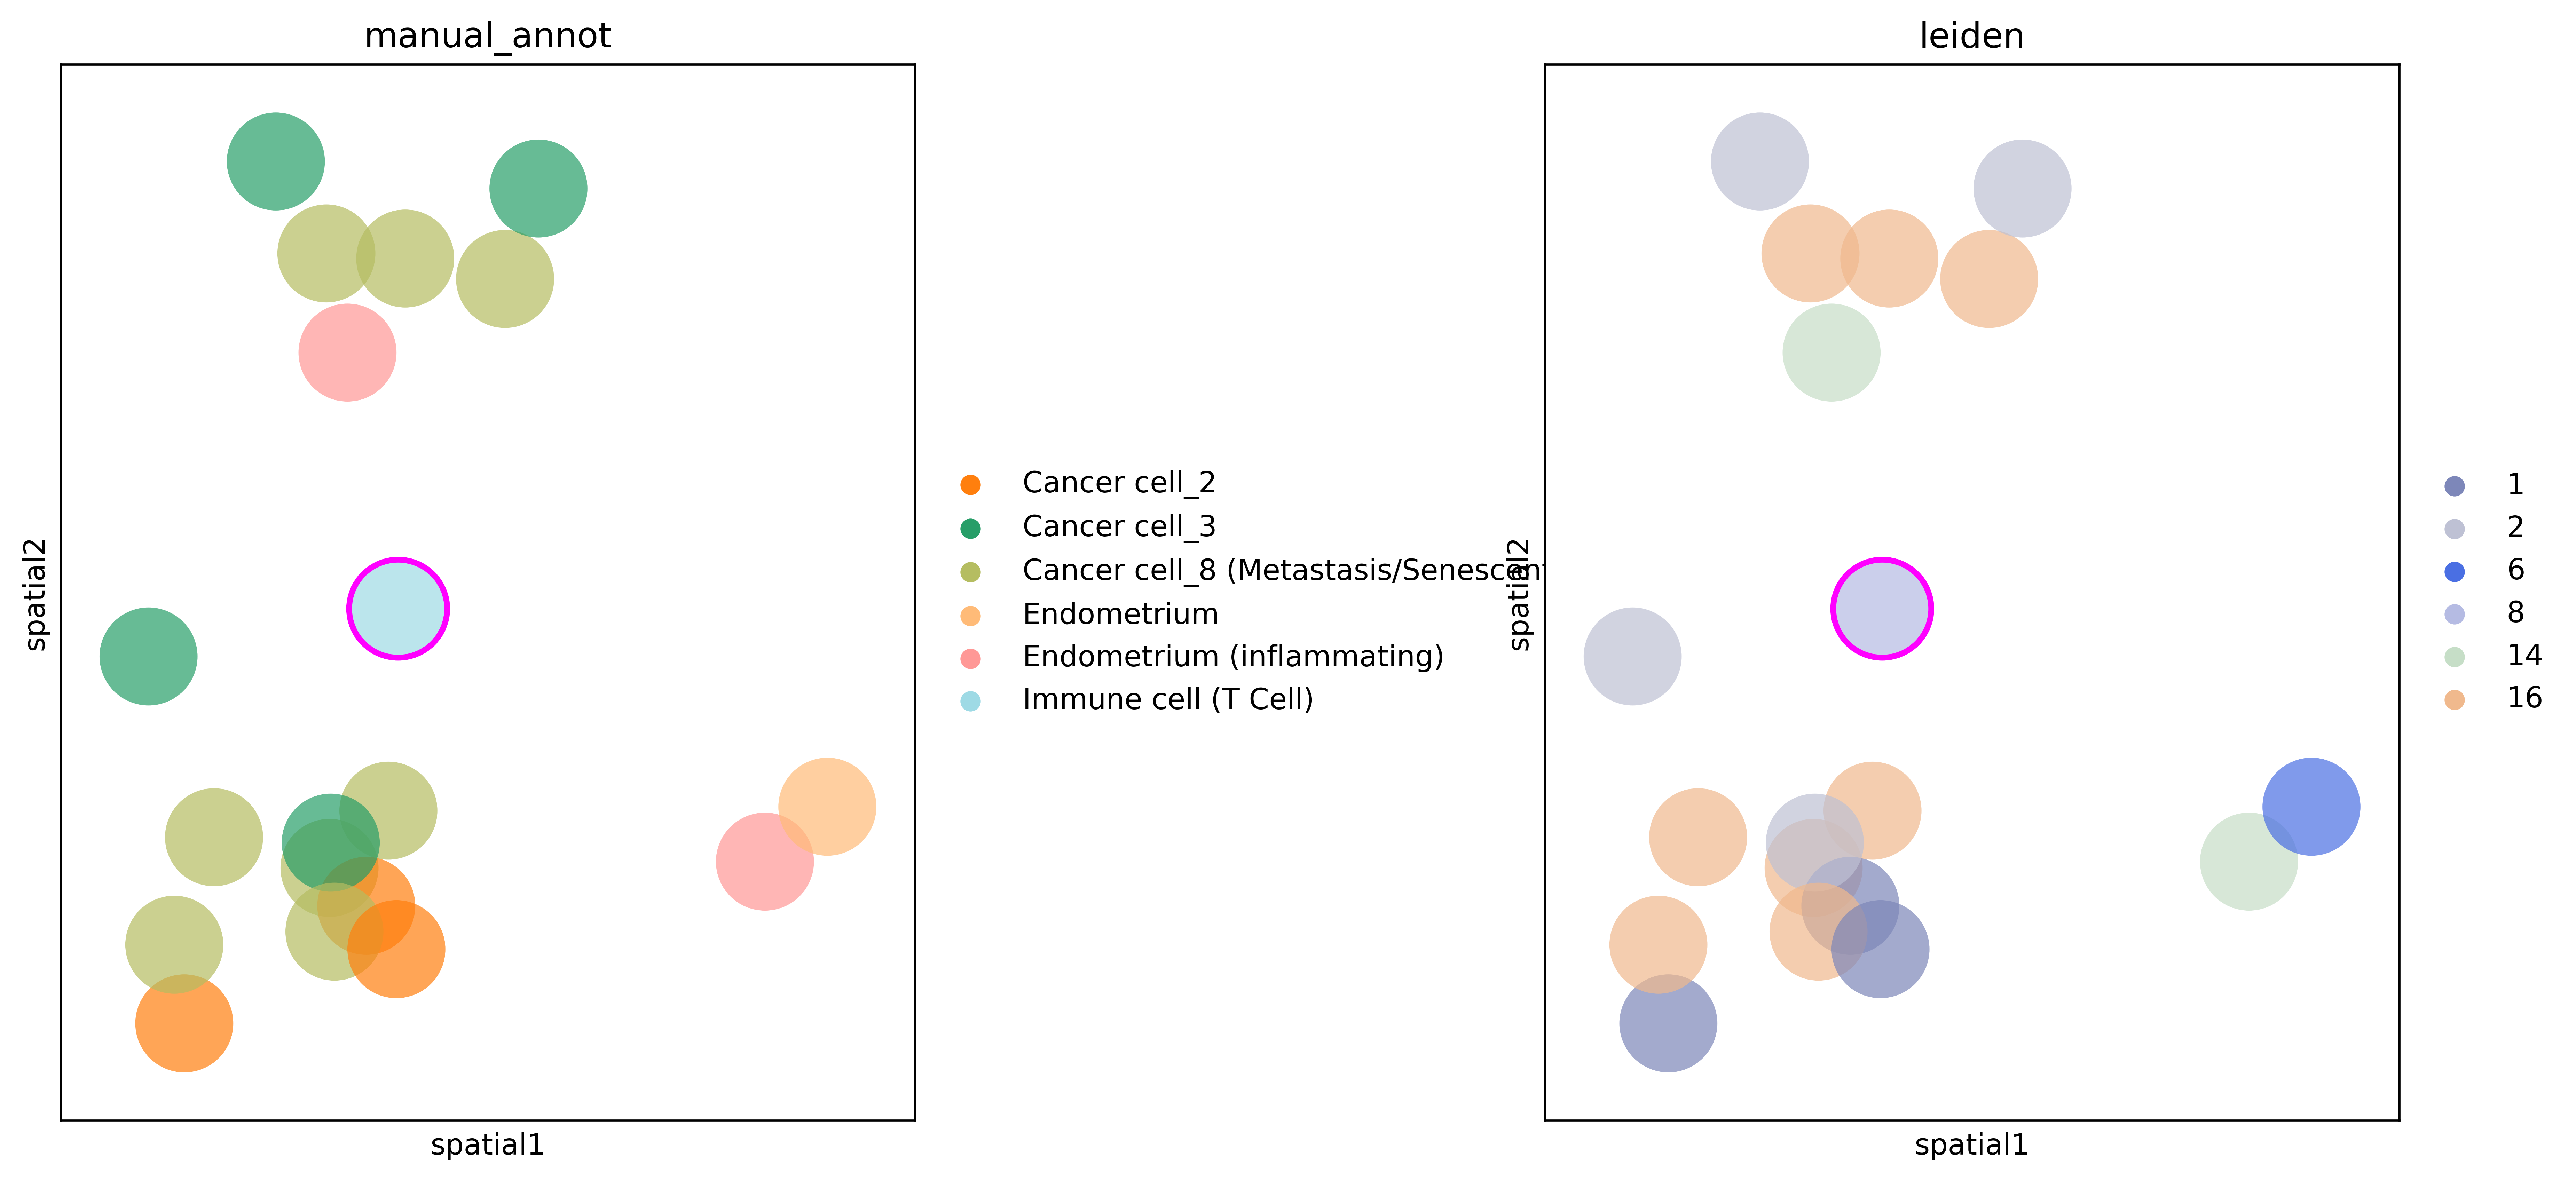

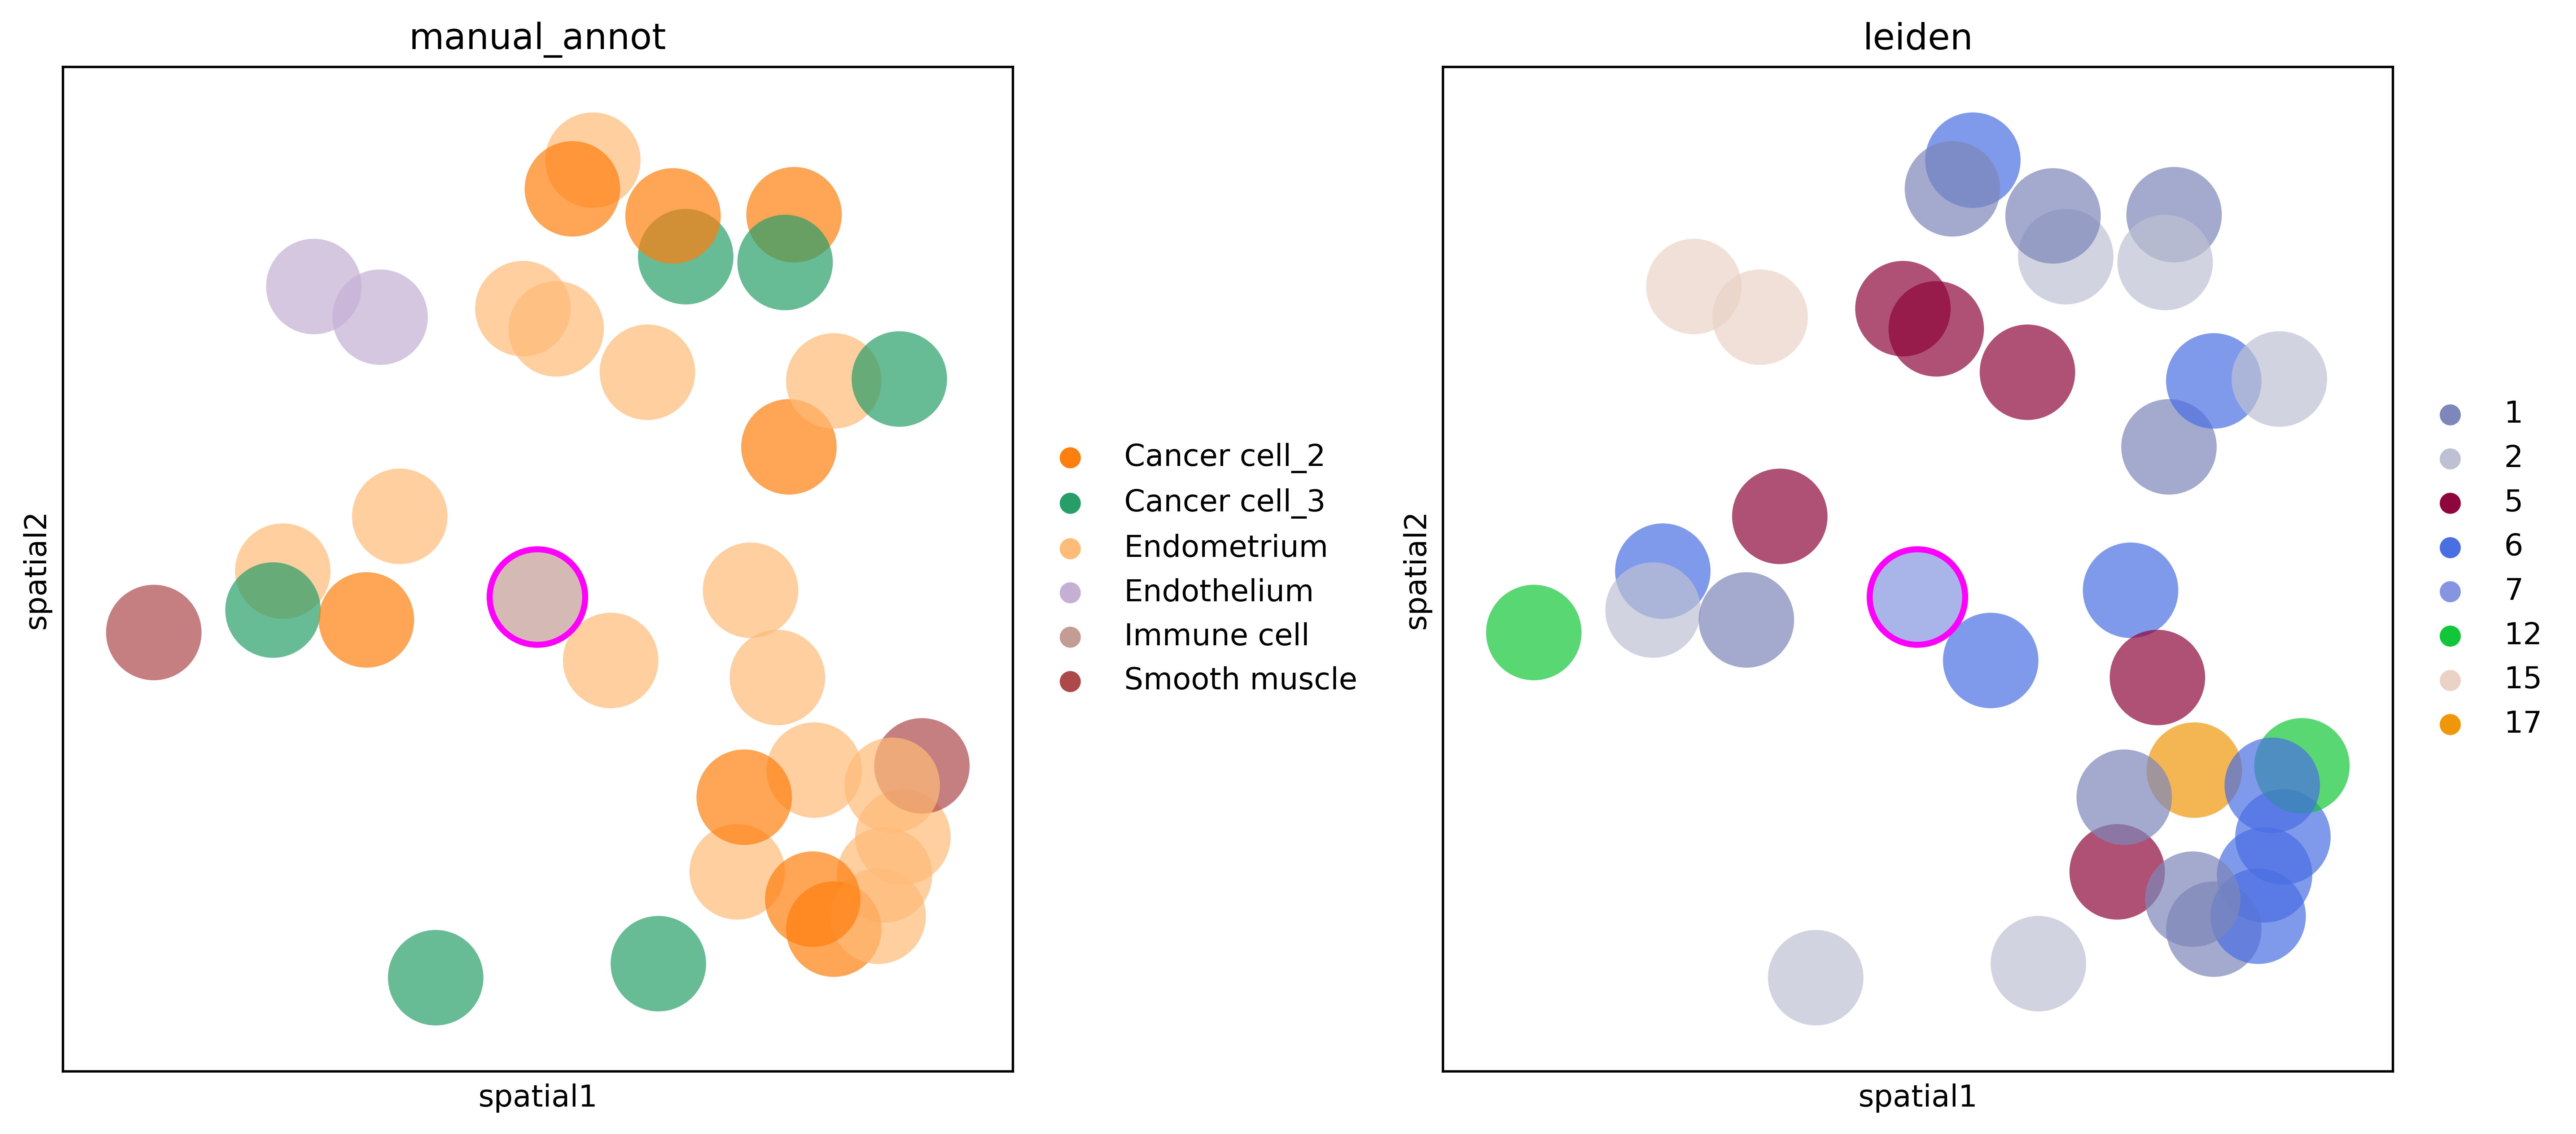

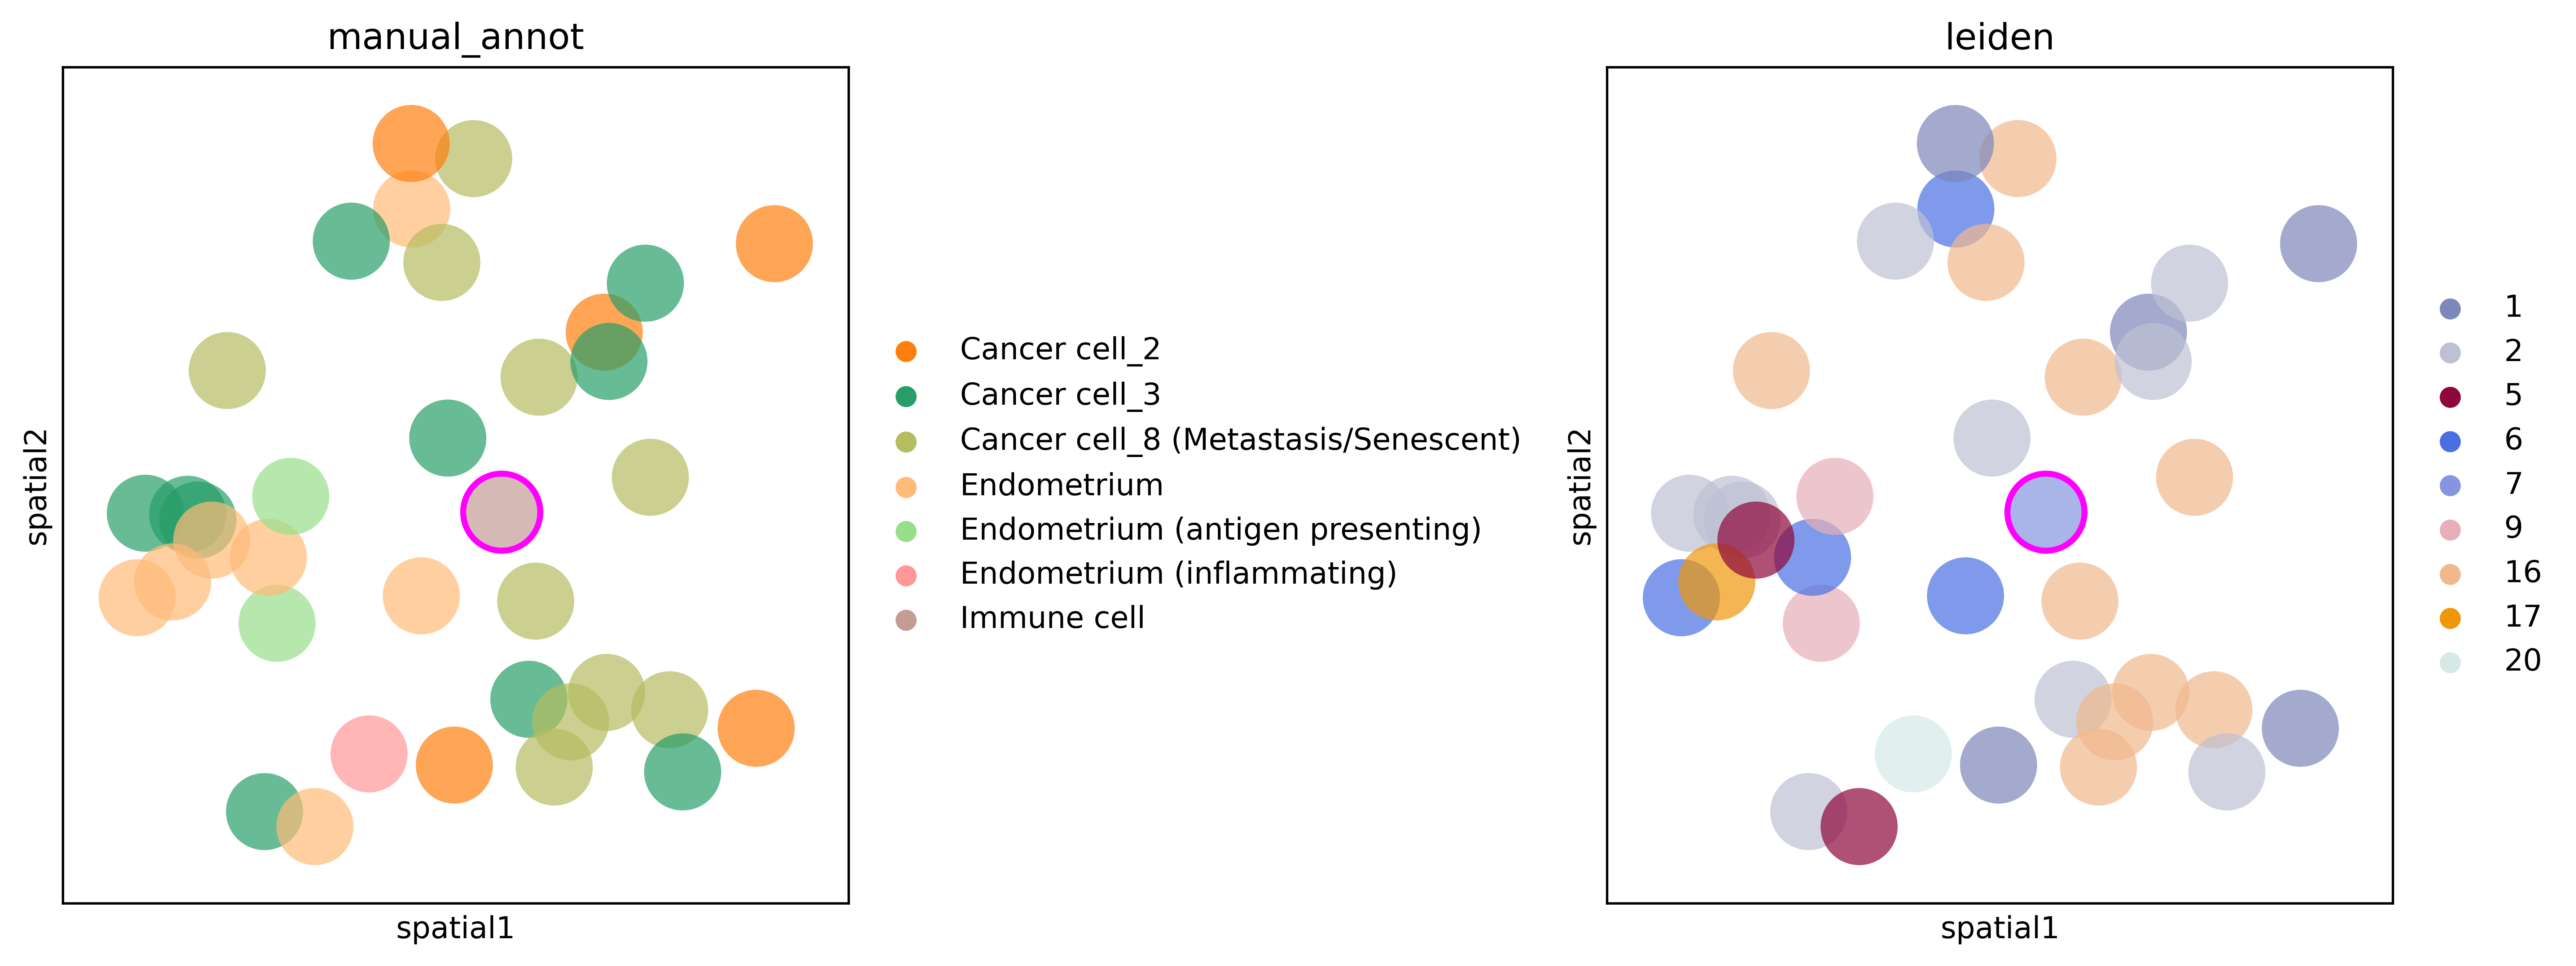

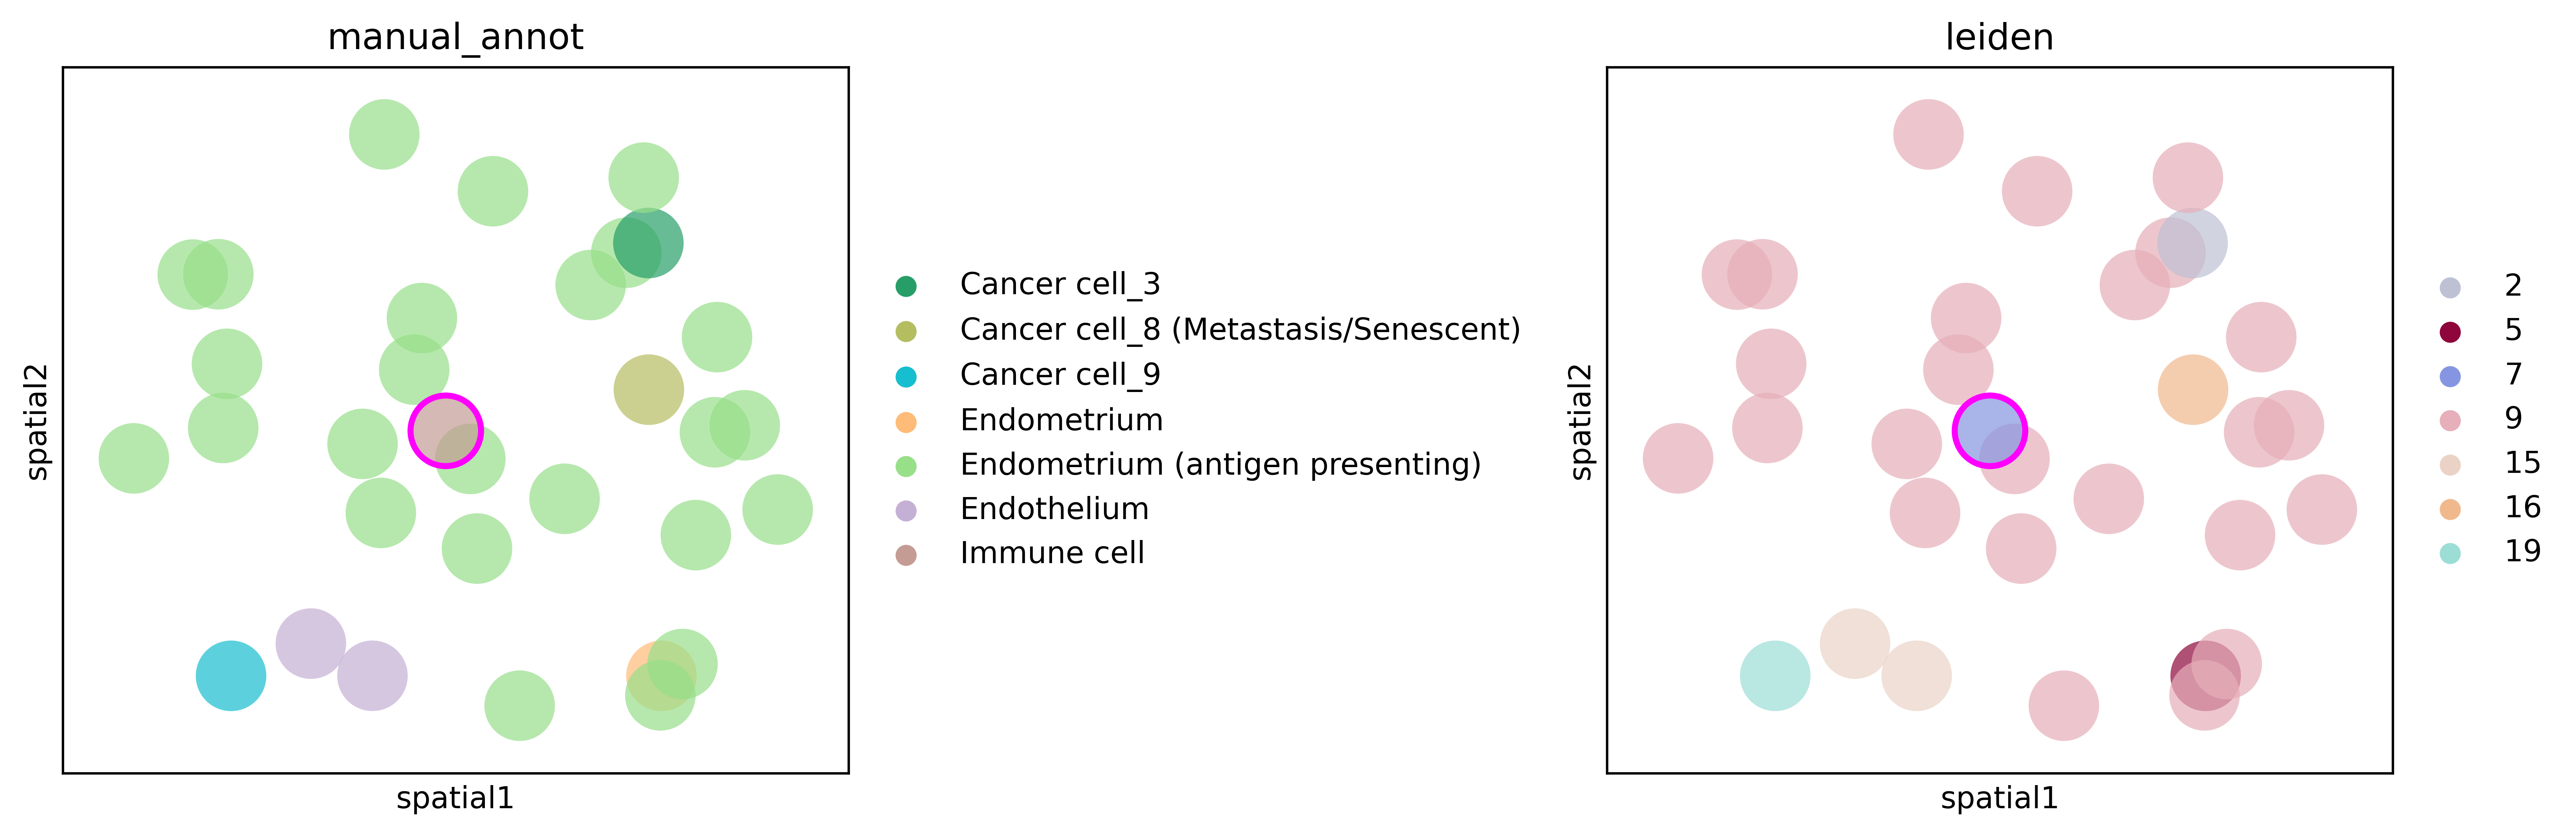

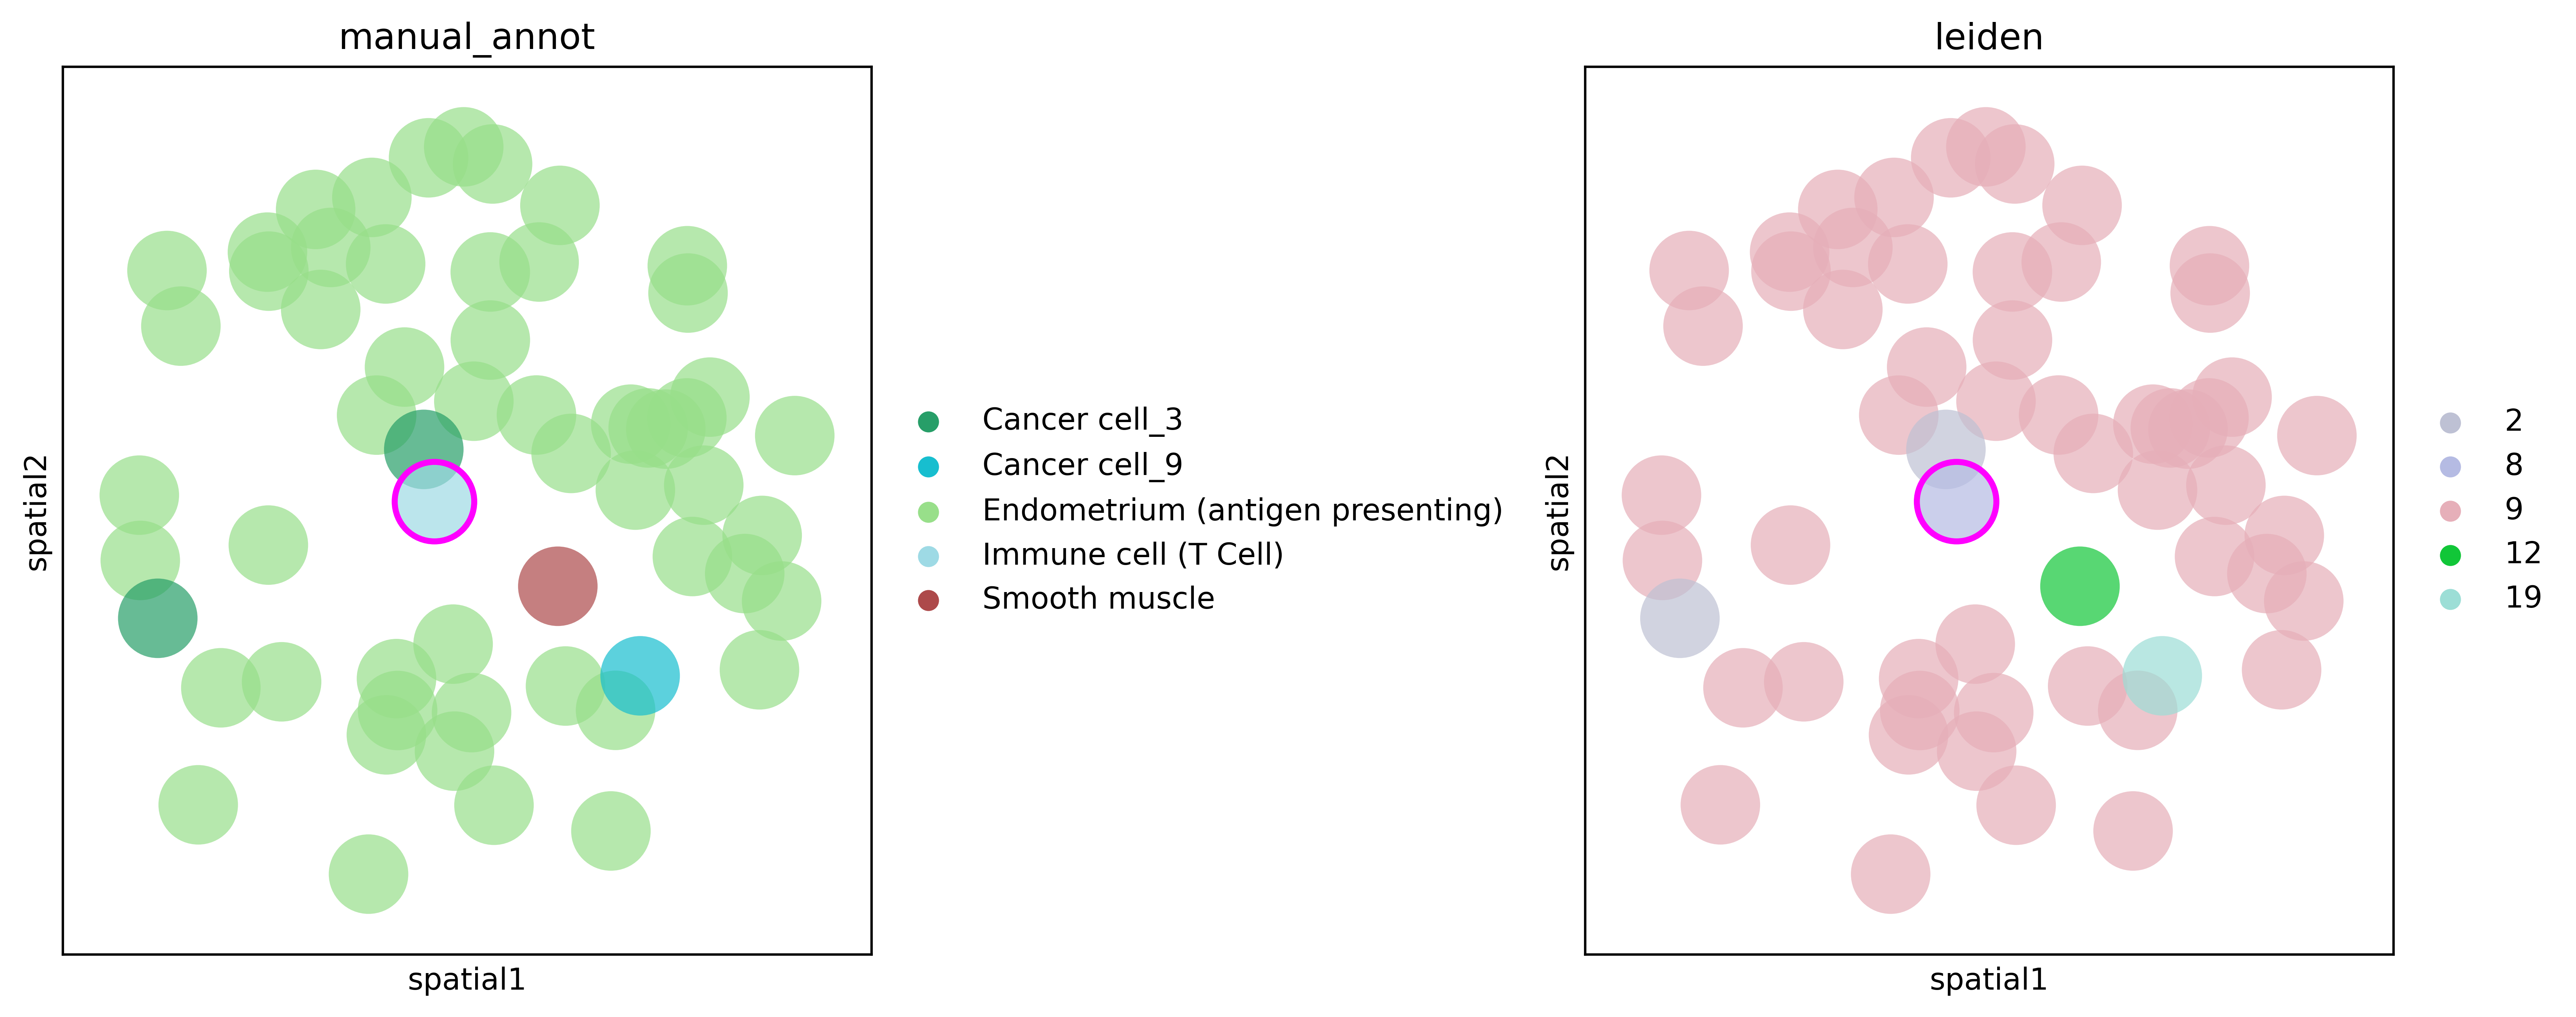

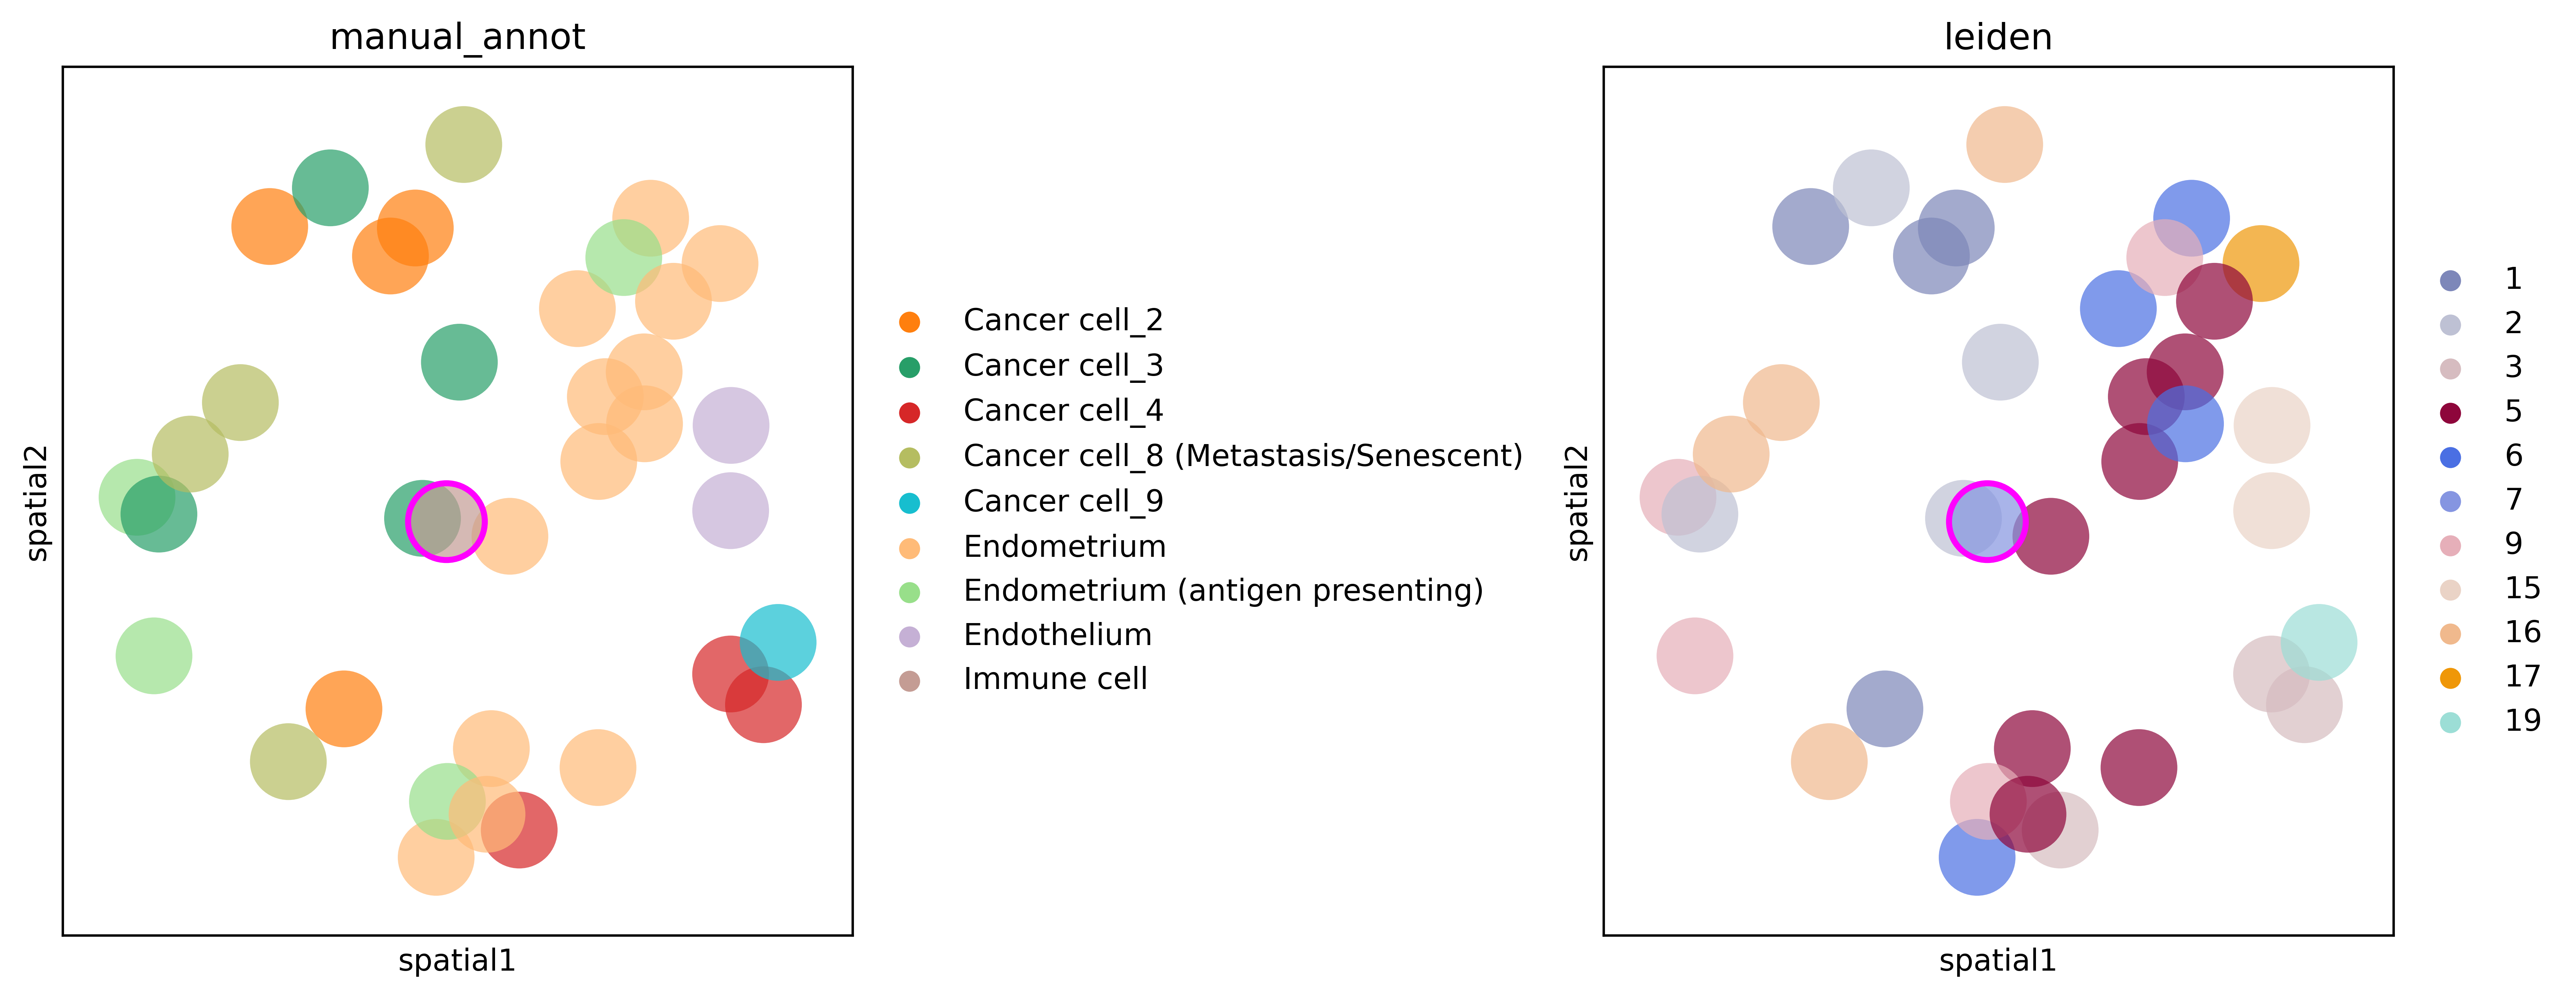

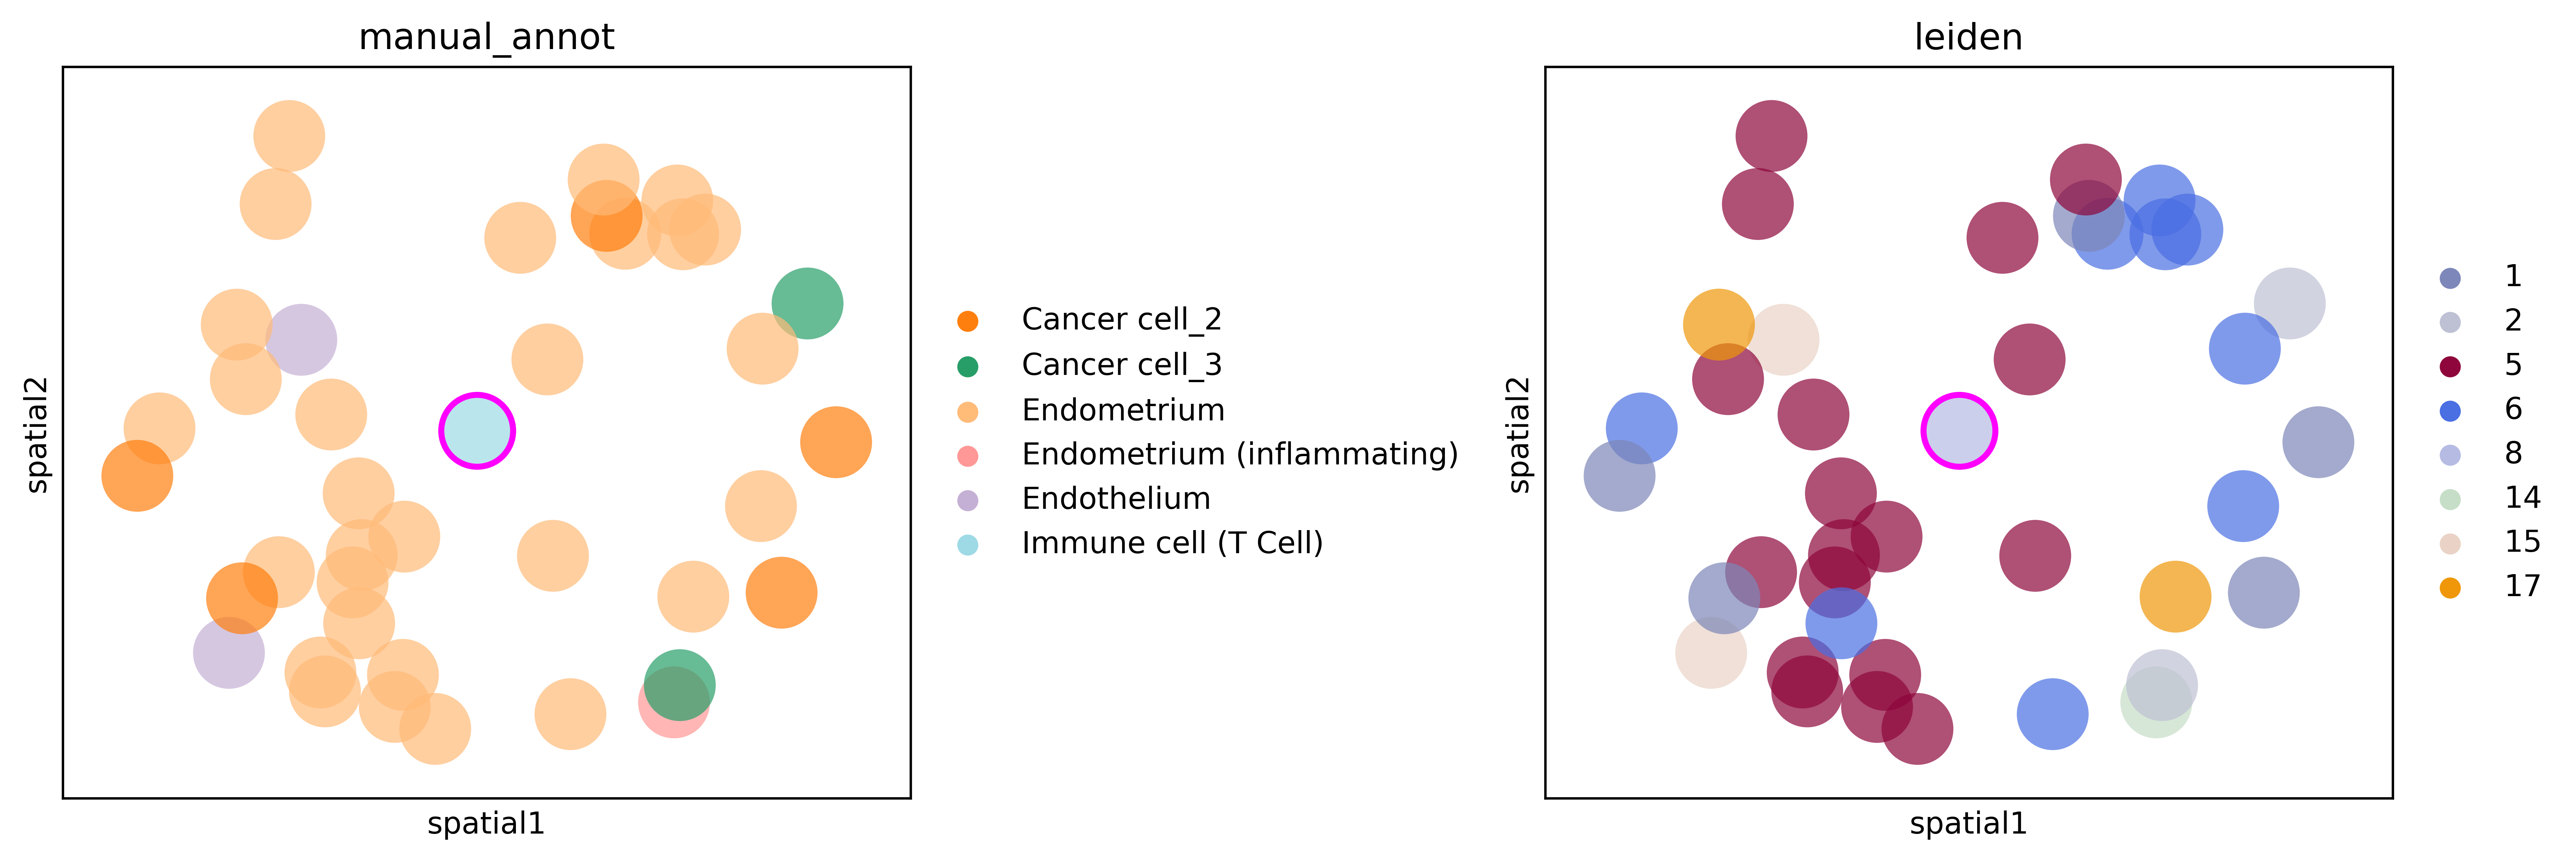

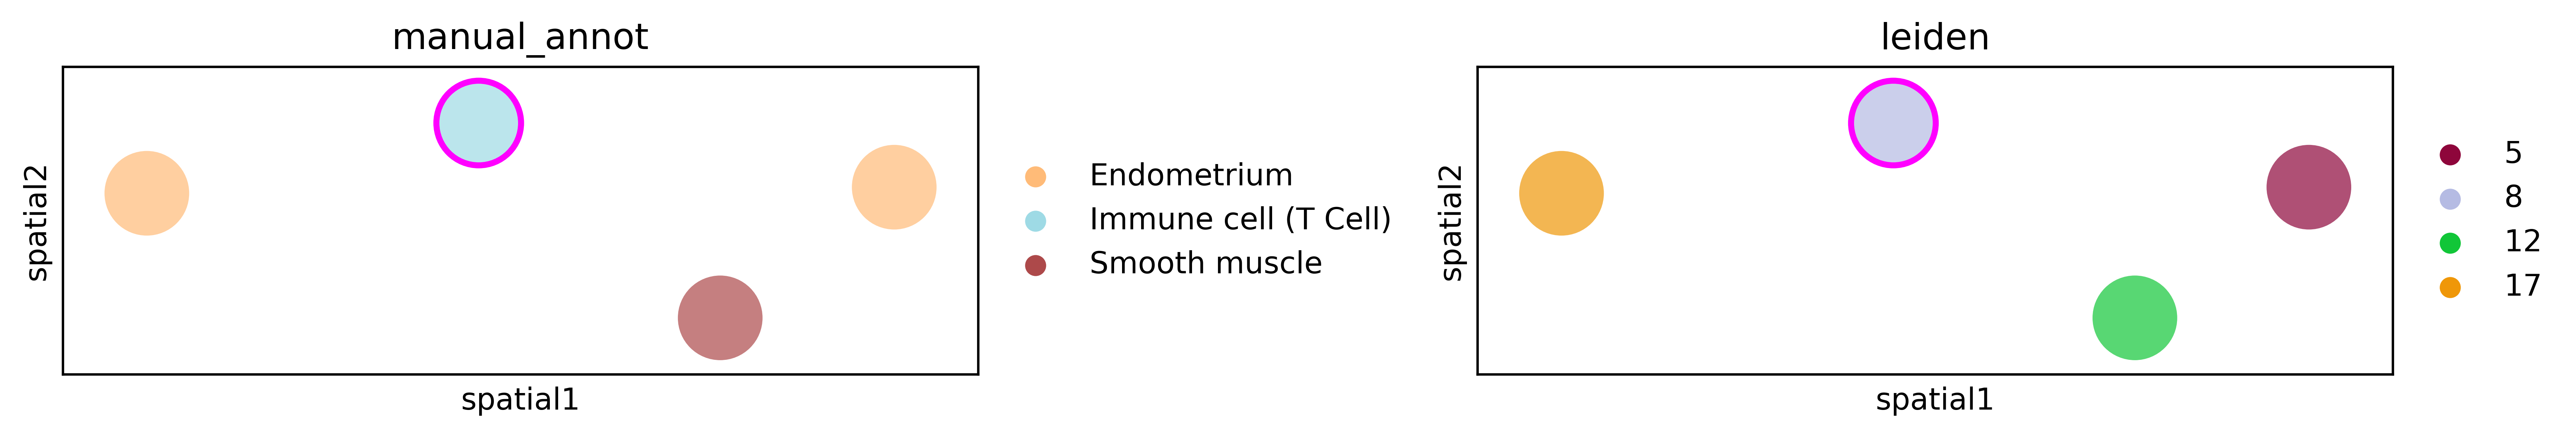

In [12]:
import random
from matplotlib.patches import Circle

random.seed(126)

n_hubs_nb_to_plot = 10

random_hub_cells = random.sample(list(hub_cell_id), n_hubs_nb_to_plot)

col_to_plot = ['manual_annot', 'leiden']

for hc in random_hub_cells:
    id_to_plot = cell_from_hub.loc[cell_from_hub['source'] == hc, 'target'].to_list() + [hc]
  
    highlight_coords = ad.obsm['spatial'][ad.obs.index == hc,]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=600)  # 1 row, 2 columns

    # Set rc_context for consistent plotting
    with rc_context({'savefig.dpi': 600}):
        # Loop through columns to plot in the subplots
        for ax, col in zip(axes, col_to_plot):
            sc.pl.spatial(ad[id_to_plot], color=col, spot_size=20, alpha=0.7, ax=ax, show=False)
            
            # Add red circle(s) to the subplot for highlighting
            for (x, y) in highlight_coords:
                circle = Circle((x, y), radius=10, edgecolor='magenta', facecolor='none', lw=2)
                ax.add_patch(circle)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Proximal-distal cell type proportion analysis
Use aribitrary thresholds to distinguish proximal and distal cells from hub cells (immune cells)

In [13]:
# define proximal-distal distance cut-offs
proximal_cut = 10
distal_cut = 50

In [14]:
filtered_distances = cell_from_hub.copy() # Use .copy() to avoid SettingWithCopyWarning
filtered_distances = filtered_distances.sort_values('distance', ascending = True)
print(len(filtered_distances))
filtered_distances = filtered_distances[~filtered_distances['target'].duplicated(keep = 'first')] # get unique target cells
filtered_distances

265833


source              target   distance  \
2758477  267305200028200732  267305200028101632   3.612607   
1237972  267305200110102619  267305200110102622   3.796181   
697622   267305200071100438  267305200071100442   4.081685   
1171754  267305200256100475  267305200256200242   4.128892   
1296443  267305200152201251  267305200152102316   4.270382   
...                     ...                 ...        ...   
1814580  267305200391101899  267305200391200687  99.971032   
761740   267305200353101775  267305200353102468  99.979229   
813809   267305200412104318  267305200413103438  99.981004   
1953484  267305200434101880  267305200434102516  99.992698   
1078136  267305200407100829  267305200407100598  99.994192   

             source_cell_type                      target_cell_type  
2758477           Immune cell      Endometrium (antigen presenting)  
1237972           Immune cell  Cancer cell_8 (Metastasis/Senescent)  
697622            Immune cell                         Cancer cell_3  
1171754           Immune cell            Endometrium (inflammating)  
1296443  Immune cell (T Cell)                         Cancer cell_3  
...                       ...                                   ...  
1814580           Immune cell                         Cancer cell_5  
761740   Immune cell (T Cell)                      Cancer stem cell  
813809            Immune cell                         Cancer cell_5  
1953484           Immune cell                         Cancer cell_5  
1078136  Immune cell (T Cell)                         Cancer cell_1  

[56203 rows x 5 columns]

In [15]:
proximal_df = filtered_distances[filtered_distances['distance'] <= proximal_cut].copy()
print(f'Number of proximal cells: {len(proximal_df)}')

distal_df = filtered_distances[(filtered_distances['distance'] > proximal_cut) & (filtered_distances['distance'] <= distal_cut)].copy()
print(f'Number of distal cells: {len(distal_df)}')

Number of proximal cells: 1381
Number of distal cells: 29886


C:\Users\ChengYiChen\AppData\Local\Temp\ipykernel_1972\2179327260.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


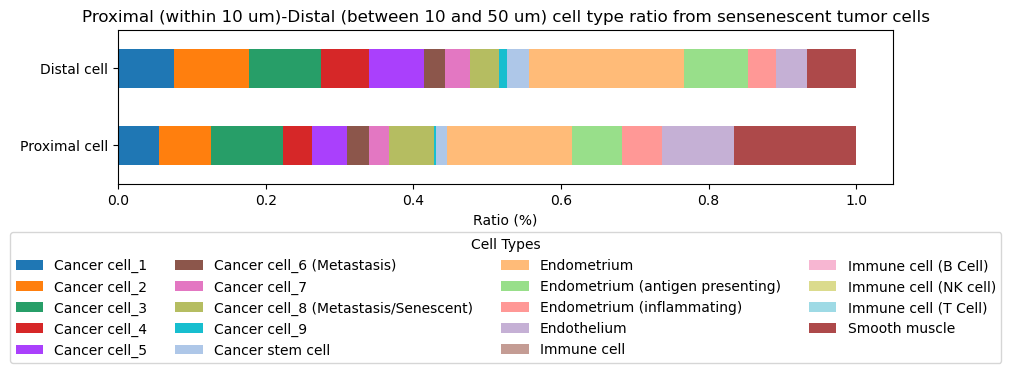

In [16]:
# Check the composition of proximal and distal cells
proximal_ratios = proximal_df['target_cell_type'].value_counts(normalize=True).sort_index()
distal_ratios = distal_df['target_cell_type'].value_counts(normalize=True).sort_index()

df_to_plot = pd.DataFrame({'Proximal cell' : proximal_ratios,
              'Distal cell' : distal_ratios}, index = ad.obs['manual_annot'].cat.categories).fillna(0).T

# Map colors from the dictionary to the dataframe columns
manual_annot_color_dict = dict(zip(ad.obs['manual_annot'].cat.categories, ad.uns['manual_annot_colors']))

colors = [manual_annot_color_dict.get(col, '#333333') for col in df_to_plot.columns]

# Creating the horizontal stacked bar plot with specified colors
ax = df_to_plot.plot(kind="barh", stacked=True, figsize=(10, 1 * len(df_to_plot)), color=colors)

# Adding labels and title
plt.xlabel("Ratio (%)")
plt.ylabel("")
plt.title(f'Proximal (within {proximal_cut} um)-Distal (between {proximal_cut} and {distal_cut} um) cell type ratio from sensenescent tumor cells')

# Adjusting the legend
plt.legend(
    loc='upper center',  # Position the legend at the top center of the plot
    bbox_to_anchor=(0.5, -0.27),  # Move the legend below the plot
    ncol=4,  # Arrange the legend in 3 columns
    title="Cell Types"  # Optional: Add a title for the legend
)

# Display the plot
plt.tight_layout()
plt.show()


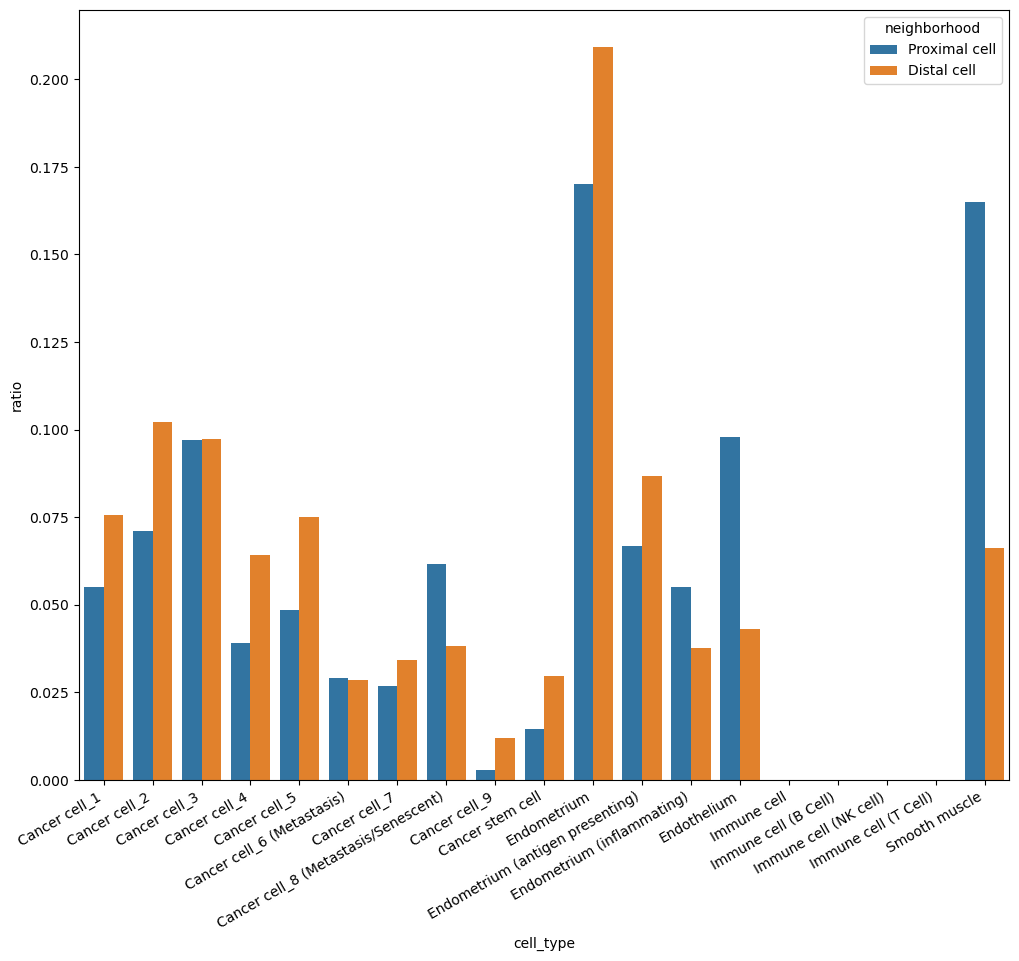

In [17]:
# compare cell type ratio side-by-side
df_to_plot = df_to_plot.reset_index(names = 'neighborhood').melt(id_vars = 'neighborhood', var_name = 'cell_type', value_name = 'ratio')

plt.figure(figsize=(12, 10))

sns.barplot(df_to_plot, x="cell_type", y="ratio", hue="neighborhood")

plt.xticks(rotation=30, ha = 'right')

# Show the plot
plt.show()

# Proximal-distal tumor cell DGE
Test whether tumor cells closer to immune cells have differential gene expression

There are 1381 proximal cells
There are 29886 distal cells


fov       volume     center_x     center_y        min_x  \
267305200243102666   947  1019.878329  6479.705659  6127.012510  6473.650219   
267305200094100399   222   968.067373  5418.534838  2121.554852  5411.394965   
267305200328101468  1258   617.736811  7211.676127  7979.333851  7207.143693   
267305200027201199    88   894.043838  3266.506581   829.868601  3261.558360   
267305200107100921   316   108.588904  1047.482169  2701.649009  1046.035597   
...                  ...          ...          ...          ...          ...   
267305200069103317   233   159.237635  3384.668263  2032.758549  3382.084087   
267305200135200490   431  1350.226370  4763.951383  3280.149611  4756.820241   
267305200027103684    87   539.226975  3519.342395   945.021176  3514.481500   
267305200215101543   829   183.530557  3037.604671  5392.436068  3035.503794   
267305200237100747   897   513.567784  3343.872983  5791.332509  3337.485570   

                          min_y        max_x        max_y  anisotropy  \
267305200243102666  6119.482103  6485.393754  6133.140532    1.285171   
267305200094100399  2117.220623  5425.523318  2127.617478    1.398084   
267305200328101468  7974.911205  7216.262823  7983.050772    1.127940   
267305200027201199   824.796660  3273.519555   834.884991    1.186773   
267305200107100921  2699.139587  1048.885309  2703.943714    1.701196   
...                         ...          ...          ...         ...   
267305200069103317  2030.336293  3387.166141  2035.159486    1.734472   
267305200135200490  3272.875593  4770.382576  3286.512923    1.163035   
267305200027103684   940.296023  3523.552940   949.419985    1.867318   
267305200215101543  5388.722238  3039.406523  5396.131594    2.388704   
267305200237100747  5788.175698  3350.443858  5794.448766    2.676366   

                    transcript_count  ...  Cellbound1_high_pass     PolyT_raw  \
267305200243102666              1221  ...          2.289069e+06  7.881190e+08   
267305200094100399               672  ...          2.738715e+06  8.020034e+08   
267305200328101468               531  ...          2.209649e+06  6.260304e+08   
267305200027201199               587  ...          2.131802e+07  8.250487e+08   
267305200107100921               108  ...          7.067444e+05  7.983360e+07   
...                              ...  ...                   ...           ...   
267305200069103317               262  ...          1.452817e+06  1.538622e+08   
267305200135200490               730  ...          4.871033e+06  1.148983e+09   
267305200027103684               543  ...          4.388450e+06  3.587144e+08   
267305200215101543                43  ...          2.493903e+06  5.630110e+07   
267305200237100747               233  ...          5.926141e+06  1.667735e+08   

                    PolyT_high_pass      DAPI_raw  DAPI_high_pass  \
267305200243102666     6.399775e+06  1.418779e+09    3.205114e+07   
267305200094100399     4.363701e+06  1.318625e+09    2.023693e+07   
267305200328101468     3.156383e+06  9.715324e+08    1.025312e+07   
267305200027201199     6.619220e+06  1.404737e+09    2.268341e+07   
267305200107100921     5.970702e+05  1.360583e+08    2.316530e+06   
...                             ...           ...             ...   
267305200069103317     1.316019e+06  1.910057e+08    3.506926e+06   
267305200135200490     6.589288e+06  2.011437e+09    2.802851e+07   
267305200027103684     2.374031e+06  6.801442e+08    1.048992e+07   
267305200215101543     5.759103e+05  1.986256e+08    2.650832e+06   
267305200237100747     1.098080e+06  5.385012e+08    6.569641e+06   

                    barcodeCount  volume_factor  leiden  \
267305200243102666          1230       1.584420      12   
267305200094100399           685       1.503929       1   
267305200328101468           532       0.959678       3   
267305200027201199           589       1.388931       9   
267305200107100921           109       0.168697       2   
...                        

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['proximal-distal_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


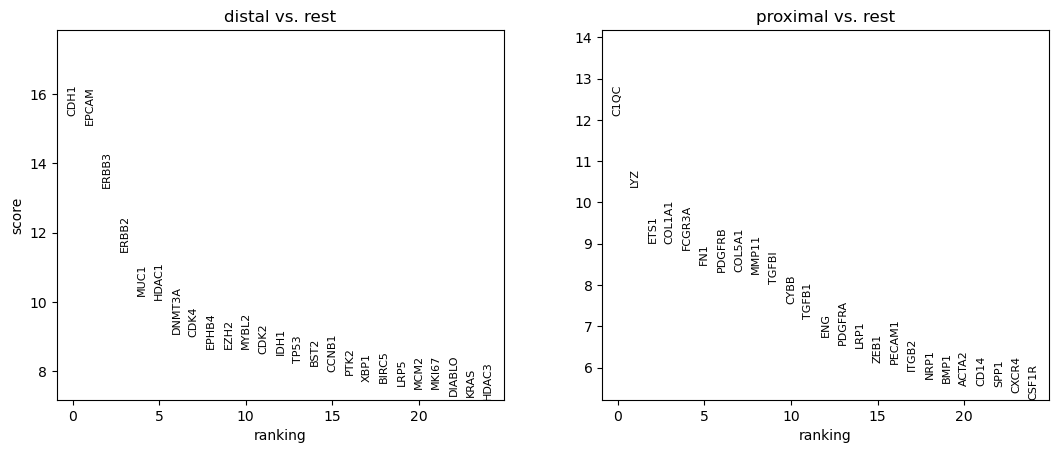

Top 10 logfoldchanges:


group   names     scores  logfoldchanges         pvals     pvals_adj
500  proximal    C1QC  12.106733        2.380352  9.729215e-34  1.216152e-31
501  proximal     LYZ  10.383063        2.010929  2.961194e-25  2.467661e-23
507  proximal  COL5A1   8.316032        1.918877  9.095723e-17  2.165648e-15
506  proximal  PDGFRB   8.327245        1.854606  8.274568e-17  2.068642e-15
505  proximal     FN1   8.490468        1.765995  2.058064e-17  5.716846e-16
509  proximal   TGFBI   8.033407        1.653459  9.480215e-16  1.896043e-14
504  proximal  FCGR3A   8.853091        1.483857  8.512796e-19  3.274152e-17
524  proximal   CSF1R   5.221811        1.477327  1.771818e-07  1.042293e-06
502  proximal    ETS1   9.016987        1.464378  1.933330e-19  9.566724e-18
513  proximal  PDGFRA   6.541824        1.452698  6.077285e-11  6.330505e-10
0      distal    CDH1  15.385117        2.412120  2.060052e-53  1.030026e-50
2      distal   ERBB3  13.305539        2.329304  2.149373e-40  3.582288e-38
1      distal   EPCAM  15.103058        2.293341  1.545951e-51  3.864877e-49
4      distal    MUC1  10.185724        1.869196  2.296427e-24  1.640305e-22
6      distal  DNMT3A   9.096825        1.695229  9.301170e-20  5.167316e-18
10     distal   MYBL2   8.640698        1.668831  5.587049e-18  1.745953e-16
15     distal   CCNB1   7.979074        1.628416  1.474354e-15  2.835295e-14
3      distal   ERBB2  11.457503        1.543436  2.156421e-30  2.156421e-28
9      distal    EZH2   8.649835        1.534472  5.157432e-18  1.719144e-16
27     distal   LAMC2   6.995857        1.523887  2.636424e-12  3.295530e-11

Top 10 z-scores:


group   names     scores  logfoldchanges         pvals     pvals_adj
500  proximal    C1QC  12.106733        2.380352  9.729215e-34  1.216152e-31
501  proximal     LYZ  10.383063        2.010929  2.961194e-25  2.467661e-23
502  proximal    ETS1   9.016987        1.464378  1.933330e-19  9.566724e-18
503  proximal  COL1A1   8.998127        1.047984  2.296014e-19  9.566724e-18
504  proximal  FCGR3A   8.853091        1.483857  8.512796e-19  3.274152e-17
505  proximal     FN1   8.490468        1.765995  2.058064e-17  5.716846e-16
506  proximal  PDGFRB   8.327245        1.854606  8.274568e-17  2.068642e-15
507  proximal  COL5A1   8.316032        1.918877  9.095723e-17  2.165648e-15
508  proximal   MMP11   8.275064        1.258671  1.283869e-16  2.917883e-15
509  proximal   TGFBI   8.033407        1.653459  9.480215e-16  1.896043e-14
0      distal    CDH1  15.385117        2.412120  2.060052e-53  1.030026e-50
1      distal   EPCAM  15.103058        2.293341  1.545951e-51  3.864877e-49
2      distal   ERBB3  13.305539        2.329304  2.149373e-40  3.582288e-38
3      distal   ERBB2  11.457503        1.543436  2.156421e-30  2.156421e-28
4      distal    MUC1  10.185724        1.869196  2.296427e-24  1.640305e-22
5      distal   HDAC1  10.068922        0.834261  7.580467e-24  4.737792e-22
6      distal  DNMT3A   9.096825        1.695229  9.301170e-20  5.167316e-18
7      distal    CDK4   9.003597        1.102683  2.184400e-19  9.566724e-18
8      distal   EPHB4   8.658827        1.471166  4.766446e-18  1.702302e-16
9      distal    EZH2   8.649835        1.534472  5.157432e-18  1.719144e-16

In [18]:
col_for_dge = 'proximal-distal'

# subset ad for DGE

proximal_id = proximal_df['target'].to_list()
distal_id = distal_df['target'].to_list()
print(f'There are {len(proximal_id)} proximal cells')
print(f'There are {len(distal_id)} distal cells')

ad_sub = ad[ad.obs.index.isin(proximal_id + distal_id)].copy()
ad_sub.obs[col_for_dge] = ad_sub.obs.index.map(dict(zip(proximal_id + distal_id, ['proximal']*len(proximal_id) +  ['distal']*len(distal_id))))
display(ad_sub.obs)

# processing the counts within the subgroup for more accurate calculation
ad_sub.X = ad_sub.raw.X.copy()

#normalize the total reads of each cell to 1M
sc.pp.normalize_total(ad_sub, target_sum=1e6)
sc.pp.log1p(ad_sub)
#scale each gene to unit variance. Clip values exceeding standard deviation 10.
# sc.pp.scale(ad_sub, max_value=10) # skip scaling to avoid neagative values and nan in log2fc


# Run rank genes groups analysis
sc.tl.rank_genes_groups(ad_sub, col_for_dge, method='wilcoxon', use_raw=False, key_added = f'{col_for_dge}_rank_genes_groups')
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False, key = f'{col_for_dge}_rank_genes_groups')
plt.close()

# sc.get.rank_genes_groups_df(ad_sub, group = None, key = f'{col_for_dge}_rank_genes_groups')
# get the DGE table
top_n = 10

rgdf = sc.get.rank_genes_groups_df(ad_sub, group = None, key = f'{col_for_dge}_rank_genes_groups')

print(f'Top {top_n} logfoldchanges:')
display(rgdf.sort_values(['group', 'logfoldchanges'], ascending = False).groupby('group', observed=True).head(top_n))

print(f'Top {top_n} z-scores:')
display(rgdf.sort_values(['group', 'scores'], ascending = False).groupby('group', observed=True).head(top_n))

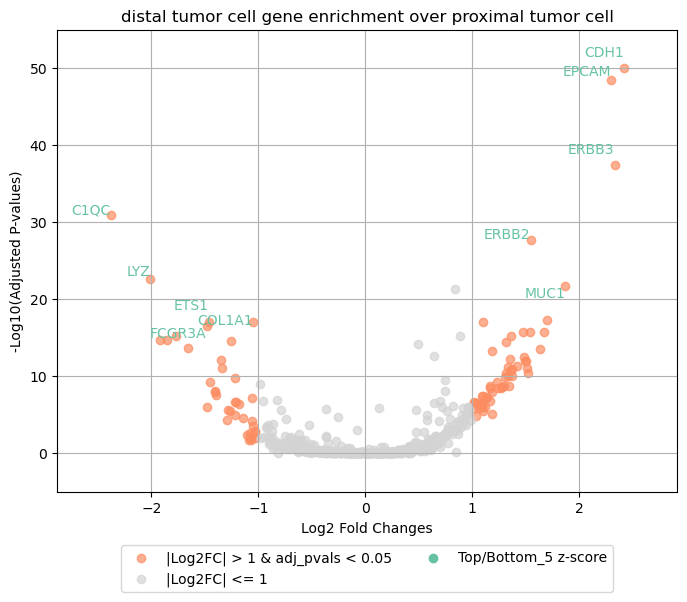

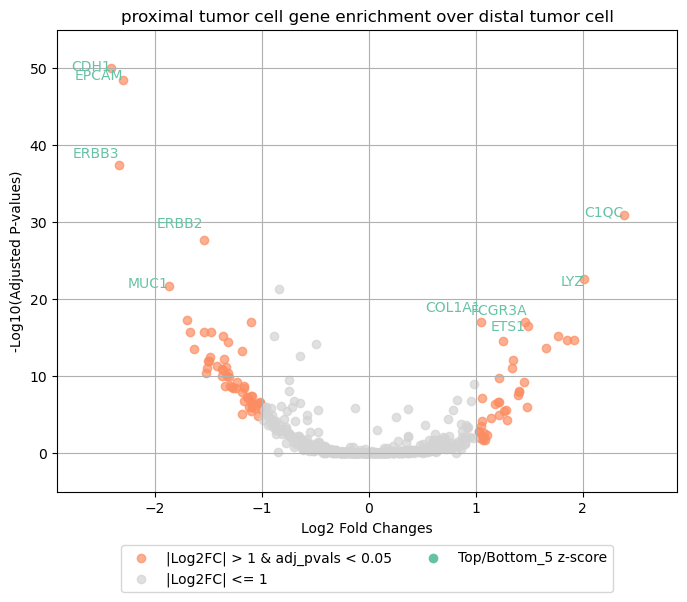

In [19]:
# Highlight top/bottom 5 scores genes

# Filter out rows where -log10(pvals_adj) is not finite
rgdf["-log10(pvals_adj)"] = -np.log10(rgdf["pvals_adj"].replace(0, np.nan))
rgdf = rgdf[np.isfinite(rgdf["-log10(pvals_adj)"])]

# Create volcano plots with labels for top and bottom n logfoldchanges
n = 5  # Number of top and bottom labels
groups = rgdf["group"].unique()

# Updated code with magenta and light gray colors for specific spots
for group in groups:
    group_rgdf = rgdf[rgdf["group"] == group]

    # Sort and select top n and bottom n based on logfoldchanges
    top_n = group_rgdf.nlargest(n, "scores")
    bottom_n = group_rgdf.nsmallest(n, "scores")
    labeled_points = pd.concat([top_n, bottom_n])
    

    plt.figure(figsize=(8, 6))

    # Plot points based on conditions for x-axis (logfoldchanges)
    plt.scatter(
        group_rgdf.loc[
            ((group_rgdf["logfoldchanges"] > 1) | (group_rgdf["logfoldchanges"] < -1)) & (group_rgdf["pvals_adj"] < 0.05),
            "logfoldchanges"
        ],
        group_rgdf.loc[
            ((group_rgdf["logfoldchanges"] > 1) | (group_rgdf["logfoldchanges"] < -1)) & (group_rgdf["pvals_adj"] < 0.05),
            "-log10(pvals_adj)"
        ],
        color='#fc8d62',
        alpha=0.7,
        label="|Log2FC| > 1 & adj_pvals < 0.05"
    )

    plt.scatter(
        group_rgdf.loc[
            (group_rgdf["logfoldchanges"] <= 1) & (group_rgdf["logfoldchanges"] >= -1),
            "logfoldchanges"
        ],
        group_rgdf.loc[
            (group_rgdf["logfoldchanges"] <= 1) & (group_rgdf["logfoldchanges"] >= -1),
            "-log10(pvals_adj)"
        ],
        color='lightgray',
        alpha=0.7,
        label="|Log2FC| <= 1"
    )

    # Add labels for the selected points with jittered y-coordinates
    for _, row in labeled_points.iterrows():
        y_jitter = np.random.uniform(-2, 2)  # Small random shift
        plt.text(
            row["logfoldchanges"],
            row["-log10(pvals_adj)"] + y_jitter,  # Apply the jitter
            row["names"],
            fontsize=10,
            ha='right',
            va='bottom',
            color='#66c2a5'
        )

    # Add a custom legend for labeled points
    plt.scatter([], [], color='#66c2a5', label=f"Top/Bottom_{n} z-score")
    # plt.scatter([], [], color='#e78ac3', label=f"Top/Bottom_{n} log2FC")

    plt.title(f"{group} tumor cell gene enrichment over {', '.join(map(str, filter(lambda x: x != group, groups)))} tumor cell")
    plt.xlabel("Log2 Fold Changes")
    plt.ylabel("-Log10(Adjusted P-values)")
    # Place legend to the bottom of the plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        frameon=True,
        ncol=2
    )

    plt.xlim(group_rgdf["logfoldchanges"].min()-0.5, group_rgdf["logfoldchanges"].max()+0.5) 
    # plt.ylim(0, 10)

    
    plt.margins(x=0.1, y=0.1) #To ensure all points and labels are visible
    plt.grid(True)
    plt.show()


# Print the environment set up

In [20]:
!pip list

Package                           Version
--------------------------------- ------------------
aext-assistant                    4.0.15
aext-assistant-server             4.0.15
aext-core                         4.0.15
aext-core-server                  4.0.15
aext-panels                       4.0.15
aext-panels-server                4.0.15
aext-share-notebook               4.0.15
aext-share-notebook-server        4.0.15
aext-shared                       4.0.15
affine                            2.4.0
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
altgraph                          0.17.4
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.3
anaconda-pro